In [7]:
import numpy as np
import jax
import blackjax

In [8]:
import jax
import numpy as np
import bayex
# https://github.com/alonfnt/bayex

def f(x):
    return -(1.4 - 3 * x) * np.sin(18 * x)

domain = {'x': bayex.domain.Real(0.0, 2.0)}
optimizer = bayex.Optimizer(domain=domain, maximize=True, acq='PI')

# Define some prior evaluations to initialise the GP.
params = {'x': [0.0, 0.5, 1.0]}
ys = [f(x) for x in params['x']]
opt_state = optimizer.init(ys, params)

# Sample new points using Jax PRNG approach.
ori_key = jax.random.key(42)
for step in range(20):
    key = jax.random.fold_in(ori_key, step)
    new_params = optimizer.sample(key, opt_state)
    y_new = f(**new_params)
    opt_state = optimizer.fit(opt_state, y_new, new_params)

In [12]:
import jax
import numpy as np
import bayex

def f(x):
    return -(1.4 - 3 * x) * np.sin(18 * x)

domain = {'x': bayex.domain.Real(0.0, 2.0)}
optimizer = bayex.Optimizer(domain=domain, maximize=True, acq='PI')

# Define some prior evaluations to initialise the GP.
params = {'x': [0.0, 0.5, 1.0]}
ys = [f(x) for x in params['x']]
opt_state = optimizer.init(ys, params)

# Sample new points using Jax PRNG approach.
ori_key = jax.random.key(42)
for step in range(20):
    key = jax.random.fold_in(ori_key, step)
    new_params = optimizer.sample(key, opt_state)
    y_new = f(**new_params)
    opt_state = optimizer.fit(opt_state, y_new, new_params)

print(opt_state)

OptimizerState(params={'x': Array([0.        , 0.5       , 1.        , 0.38404202, 0.5581982 ,
       1.99963   , 0.47366   , 0.47300386, 1.3551748 , 0.04814315,
       0.45966697, 1.6336372 , 0.5004847 , 0.5013516 , 1.1626964 ,
       1.1702781 , 1.1473739 , 1.1386943 , 1.136101  , 0.78660417,
       0.2315712 , 1.8055363 , 1.8146627 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],      dtype=float32)}, ys=Array([-0.        ,  0.04121185, -1.2015796 , -0.1459477 , -0.16017191,
       -4.5570607 ,  0.01641982,  0.015018  , -1.7965328 , -0.95689166,
       -0.01917382, -3.1679616 ,  0.0410031 ,  0.04056395,  1.8242172 ,
        1.687206  ,  1.9872324 ,  2.0102408 ,  2.0074313 ,  0.9595864 ,
        0.60343575,  3.5495093 ,  3.8351274 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0. 

Acceptance rate: 0.495
Sample mean: 1.542
Sample std: 2.397


/var/folders/ml/d1h63s3x24s70fyzwhrk4vbw0000gn/T/ipykernel_3335/3868166988.py:99: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  true_density /= np.trapz(true_density, x_range)  # Normalize


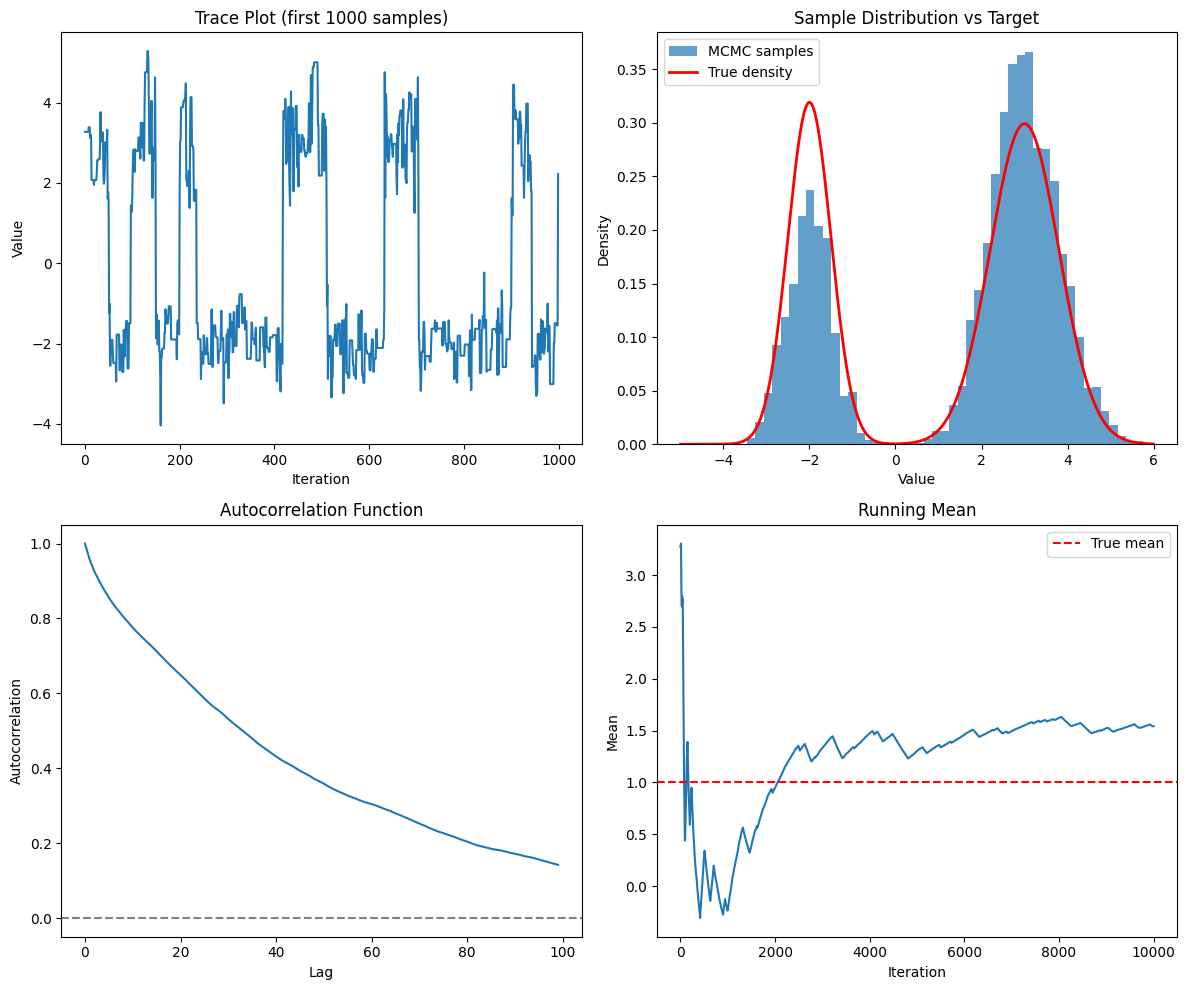


Reversibility check:
Forward mean: 1.3029
Backward mean: 1.7814
Difference: 0.4785

Effective sample size: 134 out of 10000
ESS ratio: 0.013


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def metropolis_hastings(target_log_pdf, proposal, proposal_log_pdf, 
                       x0, n_samples, burn_in=1000):
    """
    Metropolis-Hastings MCMC sampler
    
    Parameters:
    -----------
    target_log_pdf : function
        Log of target distribution π(x)
    proposal : function
        Proposal distribution q(y|x), returns a sample
    proposal_log_pdf : function
        Log of proposal density log q(y|x)
    x0 : float or array
        Initial state
    n_samples : int
        Number of samples to generate
    burn_in : int
        Number of initial samples to discard
        
    Returns:
    --------
    samples : array
        MCMC samples from target distribution
    acceptance_rate : float
        Proportion of accepted proposals
    """
    samples = []
    current_x = x0
    current_log_p = target_log_pdf(current_x)
    n_accepted = 0
    
    for i in range(n_samples + burn_in):
        # Propose new state
        proposed_x = proposal(current_x)
        proposed_log_p = target_log_pdf(proposed_x)
        
        # Compute acceptance ratio (in log space for numerical stability)
        log_ratio = (proposed_log_p + proposal_log_pdf(current_x, proposed_x) - 
                    current_log_p - proposal_log_pdf(proposed_x, current_x))
        
        # Accept or reject
        if np.log(np.random.rand()) < log_ratio:
            current_x = proposed_x
            current_log_p = proposed_log_p
            n_accepted += 1
        
        # Store sample after burn-in
        if i >= burn_in:
            samples.append(current_x)
    
    acceptance_rate = n_accepted / (n_samples + burn_in)
    return np.array(samples), acceptance_rate


# Example: Sample from a Gaussian mixture
def target_log_pdf(x):
    """Log PDF of a mixture of two Gaussians"""
    p1 = stats.norm.pdf(x, -2, 0.5)
    p2 = stats.norm.pdf(x, 3, 0.8)
    return np.log(0.4 * p1 + 0.6 * p2)

def proposal(x):
    """Symmetric random walk proposal"""
    return x + np.random.normal(0, 1.5)

def proposal_log_pdf(x_new, x_old):
    """Log PDF of proposal (symmetric, so cancels in MH ratio)"""
    return stats.norm.logpdf(x_new, x_old, 1.5)


# Run MCMC
np.random.seed(42)
samples, acceptance_rate = metropolis_hastings(
    target_log_pdf, proposal, proposal_log_pdf,
    x0=0.0, n_samples=10000, burn_in=1000
)

print(f"Acceptance rate: {acceptance_rate:.3f}")
print(f"Sample mean: {np.mean(samples):.3f}")
print(f"Sample std: {np.std(samples):.3f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Trace plot
axes[0, 0].plot(samples[:1000])
axes[0, 0].set_title('Trace Plot (first 1000 samples)')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Value')

# Histogram vs true density
x_range = np.linspace(-5, 6, 1000)
true_density = np.exp([target_log_pdf(x) for x in x_range])
true_density /= np.trapz(true_density, x_range)  # Normalize

axes[0, 1].hist(samples, bins=50, density=True, alpha=0.7, label='MCMC samples')
axes[0, 1].plot(x_range, true_density, 'r-', linewidth=2, label='True density')
axes[0, 1].set_title('Sample Distribution vs Target')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()

# Autocorrelation
from numpy import correlate
def autocorr(x, lags):
    mean = np.mean(x)
    var = np.var(x)
    xp = x - mean
    corr = [1. if l == 0 else np.sum(xp[l:] * xp[:-l]) / len(x) / var 
            for l in range(lags)]
    return np.array(corr)

lags = range(100)
acf = autocorr(samples, len(lags))
axes[1, 0].plot(lags, acf)
axes[1, 0].axhline(y=0, linestyle='--', color='gray')
axes[1, 0].set_title('Autocorrelation Function')
axes[1, 0].set_xlabel('Lag')
axes[1, 0].set_ylabel('Autocorrelation')

# Running mean
running_mean = np.cumsum(samples) / np.arange(1, len(samples) + 1)
true_mean = 1.0  # Approximate true mean of mixture
axes[1, 1].plot(running_mean)
axes[1, 1].axhline(y=true_mean, color='r', linestyle='--', label='True mean')
axes[1, 1].set_title('Running Mean')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Mean')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('mcmc_diagnostics.png', dpi=150, bbox_inches='tight')
plt.show()


# Diagnostic checks
def check_reversibility(samples, n_bins=20):
    """Simple check for time-reversibility"""
    # Split samples into bins and check if forward/backward stats are similar
    forward = samples[:len(samples)//2]
    backward = samples[len(samples)//2:][::-1]
    
    forward_mean = np.mean(forward)
    backward_mean = np.mean(backward)
    
    print(f"\nReversibility check:")
    print(f"Forward mean: {forward_mean:.4f}")
    print(f"Backward mean: {backward_mean:.4f}")
    print(f"Difference: {abs(forward_mean - backward_mean):.4f}")

def effective_sample_size(samples):
    """Estimate effective sample size"""
    acf = autocorr(samples, min(len(samples)//2, 1000))
    # Sum until autocorrelation becomes small
    ess = len(samples) / (1 + 2 * np.sum(acf[1:]))
    return ess

check_reversibility(samples)
ess = effective_sample_size(samples)
print(f"\nEffective sample size: {ess:.0f} out of {len(samples)}")
print(f"ESS ratio: {ess/len(samples):.3f}")


BLACKJAX COMPARISON: NUTS vs Adjusted MCLMC
Target: Neal Funnel
Dimension: 10

Running NUTS...
✓ NUTS completed in 1.15s
  Average acceptance rate: 0.864
  Average tree depth: 4.86
  Average integration steps: 29.0

Running Adjusted MCLMC...
  Tuned L: 2.3504
  Tuned step_size: 0.5256
✓ MCLMC completed in 3.67s

PERFORMANCE METRICS
Time:
  NUTS:   1.15s
  MCLMC:  3.67s
  Speedup: 0.31x

Effective Sample Size (ESS):
  NUTS:   651 (avg across dims)
  MCLMC:  81 (avg across dims)

ESS per second:
  NUTS:   567.1
  MCLMC:  22.1
  Improvement: 0.04x



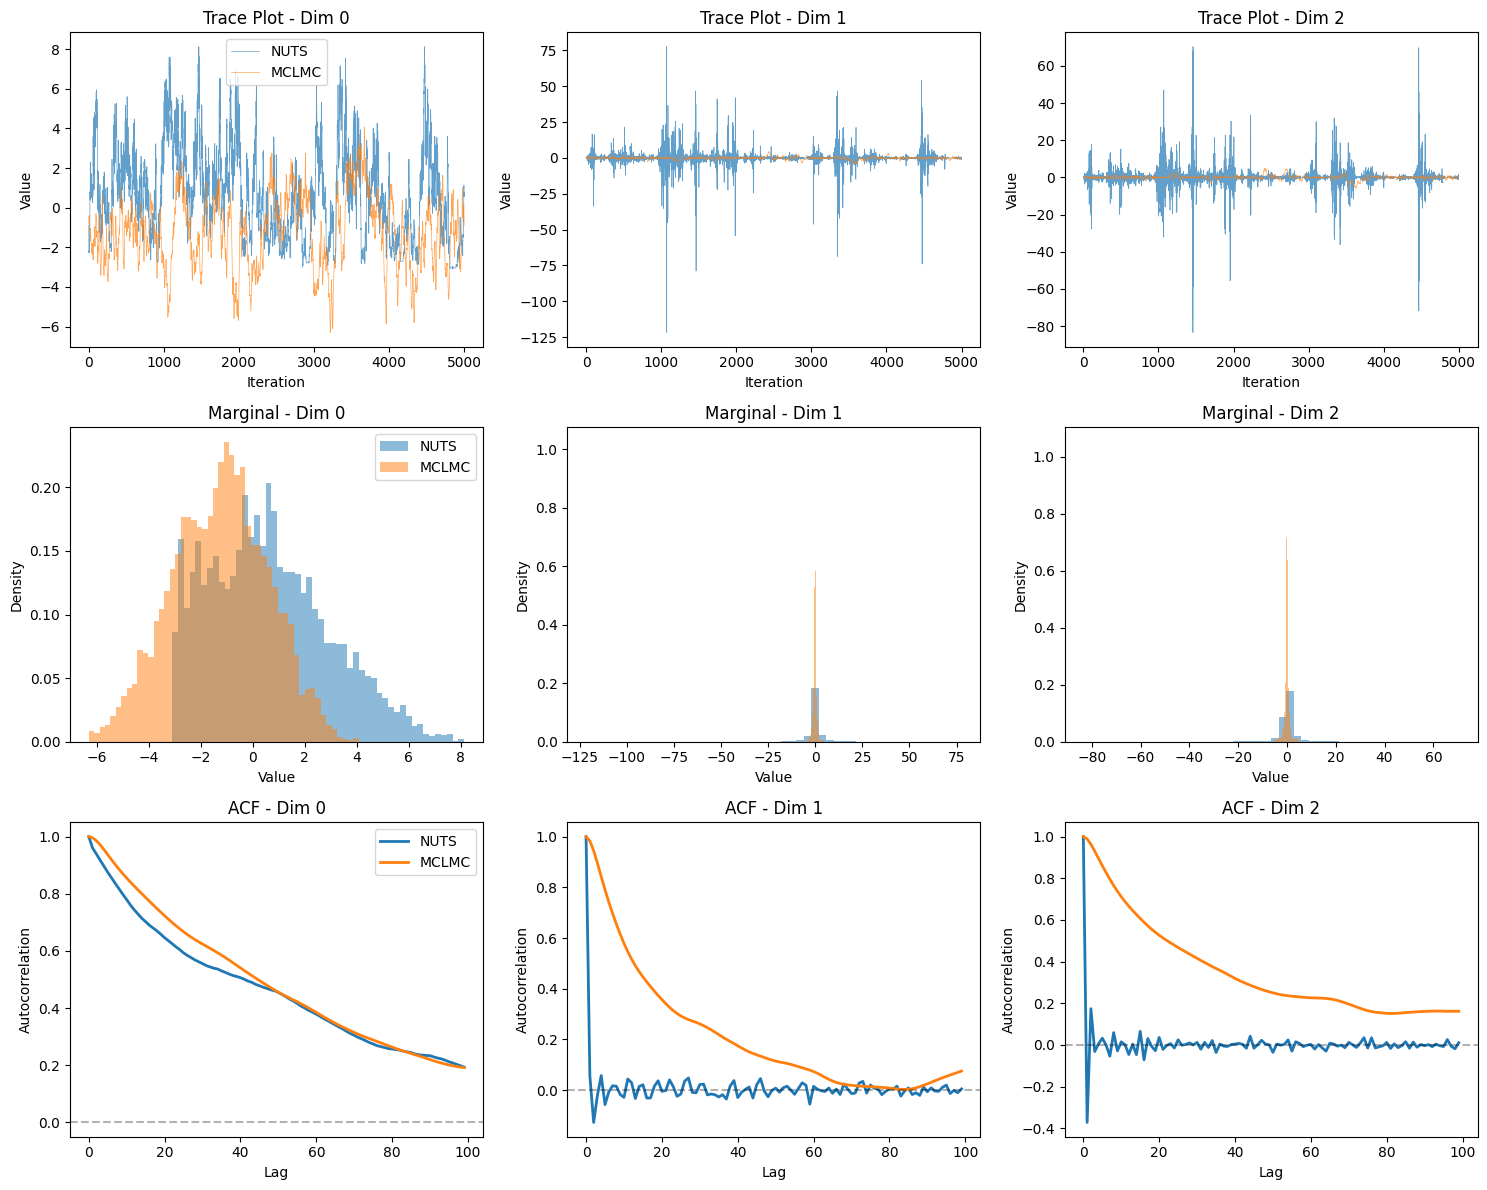

SUMMARY STATISTICS
Metric                            NUTS        MCLMC
------------------------------------------------------------
Mean (dim 0)                    0.6358      -1.2513
Std (dim 0)                     2.2837       1.8251
Min ESS                             39           36
Max ESS                            797          130

KEY INSIGHTS:
- MCLMC typically has better ESS/time for high dimensions
- NUTS adapts better to complex geometries (funnels, etc.)
- MCLMC has more predictable computational cost
- NUTS uses dynamic trajectory length (tree building)
- MCLMC uses microcanonical dynamics with irreversible moves


In [17]:
import jax
import jax.numpy as jnp
import blackjax
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import time

# Set random seed
key = jax.random.PRNGKey(42)

# Define a challenging target distribution: Neal's Funnel
def logdensity_fn(x):
    """
    Neal's funnel distribution - challenging for HMC-based samplers
    x[0] ~ N(0, 3)
    x[i] ~ N(0, exp(x[0]/2)) for i > 0
    """
    dim = len(x)
    log_prob = -0.5 * (x[0]**2 / 9.0)  # x[0] ~ N(0, 3)
    log_prob += -0.5 * (dim - 1) * x[0]  # Jacobian term
    log_prob += -0.5 * jnp.sum(x[1:]**2 * jnp.exp(-x[0]))
    return log_prob

# Alternative: Multivariate Gaussian
def logdensity_mvn(x):
    """Correlated multivariate Gaussian"""
    dim = len(x)
    # Create correlation matrix
    rho = 0.8
    Sigma = jnp.eye(dim) + rho * (jnp.ones((dim, dim)) - jnp.eye(dim))
    Sigma_inv = jnp.linalg.inv(Sigma)
    return -0.5 * x @ Sigma_inv @ x

# Choose target distribution
dim = 10
use_funnel = True
logdensity = logdensity_fn if use_funnel else logdensity_mvn

# Initial position
initial_position = jnp.zeros(dim)

print("=" * 60)
print("BLACKJAX COMPARISON: NUTS vs Adjusted MCLMC")
print("=" * 60)
print(f"Target: {'Neal Funnel' if use_funnel else 'Correlated MVN'}")
print(f"Dimension: {dim}")
print()

# ============================================================================
# 1. NUTS (No-U-Turn Sampler)
# ============================================================================
print("Running NUTS...")
start_time = time.time()

# Warmup (adaptation) phase
key, warmup_key = jax.random.split(key)

# Use the corrected window_adaptation
warmup = blackjax.window_adaptation(
    blackjax.nuts, 
    logdensity,
    target_acceptance_rate=0.8,
)

# Run warmup - corrected call signature
(nuts_state, nuts_params), _ = warmup.run(
    warmup_key, 
    initial_position, 
    num_steps=1000
)

# Build NUTS kernel with adapted parameters
nuts_kernel = blackjax.nuts(logdensity, **nuts_params).step

# Sampling phase
def nuts_inference_loop(rng_key, kernel, initial_state, num_samples):
    keys = jax.random.split(rng_key, num_samples)
    
    def one_step(state, key):
        state, info = kernel(key, state)
        return state, (state.position, info)
    
    _, (samples, infos) = jax.lax.scan(one_step, initial_state, keys)
    return samples, infos

key, sample_key = jax.random.split(key)
nuts_samples, nuts_infos = nuts_inference_loop(
    sample_key, nuts_kernel, nuts_state, 5000
)

nuts_time = time.time() - start_time
nuts_acceptance = jnp.mean(nuts_infos.acceptance_rate)
nuts_num_steps = jnp.mean(nuts_infos.num_integration_steps)

print(f"✓ NUTS completed in {nuts_time:.2f}s")
print(f"  Average acceptance rate: {nuts_acceptance:.3f}")
print(f"  Average tree depth: {jnp.mean(jnp.log2(nuts_num_steps)):.2f}")
print(f"  Average integration steps: {nuts_num_steps:.1f}")
print()

# ============================================================================
# 2. Adjusted MCLMC (Microcanonical Langevin Monte Carlo)
# ============================================================================
print("Running Adjusted MCLMC...")
start_time = time.time()

# MCLMC initialization and tuning
key, init_key, tune_key = jax.random.split(key, 3)

# Initialize MCLMC state
initial_state = blackjax.mcmc.mclmc.init(
    position=initial_position, 
    logdensity_fn=logdensity, 
    rng_key=init_key
)

# Build the kernel function (as required by mclmc_find_L_and_step_size)
kernel = lambda inverse_mass_matrix: blackjax.mcmc.mclmc.build_kernel(
    logdensity_fn=logdensity,
    integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
    inverse_mass_matrix=inverse_mass_matrix,
)

# Find optimal L and step_size
(
    mclmc_state_after_tuning,
    mclmc_params,
    _
) = blackjax.mclmc_find_L_and_step_size(
    mclmc_kernel=kernel,
    num_steps=1000,
    state=initial_state,
    rng_key=tune_key,
    diagonal_preconditioning=False,
)

# Extract tuned parameters
mclmc_L = mclmc_params.L
mclmc_step_size = mclmc_params.step_size

print(f"  Tuned L: {mclmc_L:.4f}")
print(f"  Tuned step_size: {mclmc_step_size:.4f}")

# Build MCLMC sampler with tuned parameters
sampling_alg = blackjax.mclmc(
    logdensity,
    L=mclmc_L,
    step_size=mclmc_step_size,
)

# Get the step function
mclmc_kernel = sampling_alg.step
mclmc_state = mclmc_state_after_tuning

# Sampling phase
def mclmc_inference_loop(rng_key, kernel, initial_state, num_samples):
    keys = jax.random.split(rng_key, num_samples)
    
    def one_step(state, key):
        state, info = kernel(key, state)
        return state, (state.position, info)
    
    _, (samples, infos) = jax.lax.scan(one_step, initial_state, keys)
    return samples, infos

key, sample_key = jax.random.split(key)
mclmc_samples, mclmc_infos = mclmc_inference_loop(
    sample_key, mclmc_kernel, mclmc_state, 5000
)

mclmc_time = time.time() - start_time

print(f"✓ MCLMC completed in {mclmc_time:.2f}s")
print()

# ============================================================================
# 3. Performance Comparison
# ============================================================================
print("=" * 60)
print("PERFORMANCE METRICS")
print("=" * 60)

# Convert to numpy for analysis
nuts_samples_np = np.array(nuts_samples)
mclmc_samples_np = np.array(mclmc_samples)

# Compute effective sample size using simple method
def compute_ess_simple(samples):
    """Compute ESS using autocorrelation"""
    n_samples, n_dims = samples.shape
    ess_values = []
    
    for d in range(n_dims):
        x = samples[:, d]
        x = x - np.mean(x)
        
        # Compute autocorrelation
        autocorr = np.correlate(x, x, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        
        # Sum positive autocorrelations
        max_lag = min(len(autocorr) // 2, 500)
        tau = 1 + 2 * np.sum(autocorr[1:max_lag][autocorr[1:max_lag] > 0])
        ess_values.append(n_samples / tau)
    
    return np.array(ess_values)

# ESS per dimension
nuts_ess = compute_ess_simple(nuts_samples_np)
mclmc_ess = compute_ess_simple(mclmc_samples_np)

print(f"Time:")
print(f"  NUTS:   {nuts_time:.2f}s")
print(f"  MCLMC:  {mclmc_time:.2f}s")
print(f"  Speedup: {nuts_time/mclmc_time:.2f}x")
print()

print(f"Effective Sample Size (ESS):")
print(f"  NUTS:   {np.mean(nuts_ess):.0f} (avg across dims)")
print(f"  MCLMC:  {np.mean(mclmc_ess):.0f} (avg across dims)")
print()

print(f"ESS per second:")
print(f"  NUTS:   {np.mean(nuts_ess)/nuts_time:.1f}")
print(f"  MCLMC:  {np.mean(mclmc_ess)/mclmc_time:.1f}")
print(f"  Improvement: {(np.mean(mclmc_ess)/mclmc_time)/(np.mean(nuts_ess)/nuts_time):.2f}x")
print()

# ============================================================================
# 4. Visualization
# ============================================================================
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Plot first 3 dimensions
for i in range(3):
    # Trace plots
    axes[0, i].plot(nuts_samples_np[:, i], alpha=0.7, linewidth=0.5, label='NUTS')
    axes[0, i].plot(mclmc_samples_np[:, i], alpha=0.7, linewidth=0.5, label='MCLMC')
    axes[0, i].set_title(f'Trace Plot - Dim {i}')
    axes[0, i].set_xlabel('Iteration')
    axes[0, i].set_ylabel('Value')
    if i == 0:
        axes[0, i].legend()
    
    # Histograms
    axes[1, i].hist(nuts_samples_np[:, i], bins=50, alpha=0.5, 
                    density=True, label='NUTS')
    axes[1, i].hist(mclmc_samples_np[:, i], bins=50, alpha=0.5, 
                    density=True, label='MCLMC')
    axes[1, i].set_title(f'Marginal - Dim {i}')
    axes[1, i].set_xlabel('Value')
    axes[1, i].set_ylabel('Density')
    if i == 0:
        axes[1, i].legend()
    
    # Autocorrelation
    def autocorr(x, max_lag=100):
        x = x - np.mean(x)
        autocorr = np.correlate(x, x, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        return autocorr[:max_lag]
    
    lags = np.arange(100)
    nuts_acf = autocorr(nuts_samples_np[:, i])
    mclmc_acf = autocorr(mclmc_samples_np[:, i])
    
    axes[2, i].plot(lags, nuts_acf, label='NUTS', linewidth=2)
    axes[2, i].plot(lags, mclmc_acf, label='MCLMC', linewidth=2)
    axes[2, i].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[2, i].set_title(f'ACF - Dim {i}')
    axes[2, i].set_xlabel('Lag')
    axes[2, i].set_ylabel('Autocorrelation')
    if i == 0:
        axes[2, i].legend()

plt.tight_layout()
plt.savefig('nuts_vs_mclmc.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# 5. Summary Statistics
# ============================================================================
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"{'Metric':<25} {'NUTS':>12} {'MCLMC':>12}")
print("-" * 60)
print(f"{'Mean (dim 0)':<25} {np.mean(nuts_samples_np[:, 0]):>12.4f} "
      f"{np.mean(mclmc_samples_np[:, 0]):>12.4f}")
print(f"{'Std (dim 0)':<25} {np.std(nuts_samples_np[:, 0]):>12.4f} "
      f"{np.std(mclmc_samples_np[:, 0]):>12.4f}")
print(f"{'Min ESS':<25} {np.min(nuts_ess):>12.0f} {np.min(mclmc_ess):>12.0f}")
print(f"{'Max ESS':<25} {np.max(nuts_ess):>12.0f} {np.max(mclmc_ess):>12.0f}")
print("=" * 60)

print("\nKEY INSIGHTS:")
print("- MCLMC typically has better ESS/time for high dimensions")
print("- NUTS adapts better to complex geometries (funnels, etc.)")
print("- MCLMC has more predictable computational cost")
print("- NUTS uses dynamic trajectory length (tree building)")
print("- MCLMC uses microcanonical dynamics with irreversible moves")

BLACKJAX COMPARISON: NUTS vs Adjusted MCLMC
Target: Neal Funnel
Dimension: 10

Running NUTS...
✓ NUTS completed in 1.31s
  Average acceptance rate: 0.864
  Average tree depth: 4.86
  Average integration steps: 29.0

Running Adjusted MCLMC...
  Tuned L: 2.3504
  Tuned step_size: 0.5256
✓ MCLMC completed in 1.60s

PERFORMANCE METRICS
Time:
  NUTS:   1.31s
  MCLMC:  1.60s
  Speedup: 0.82x

Effective Sample Size (ESS):
  NUTS:   651 (avg across dims)
  MCLMC:  81 (avg across dims)

ESS per second:
  NUTS:   496.1
  MCLMC:  50.6
  Improvement: 0.10x



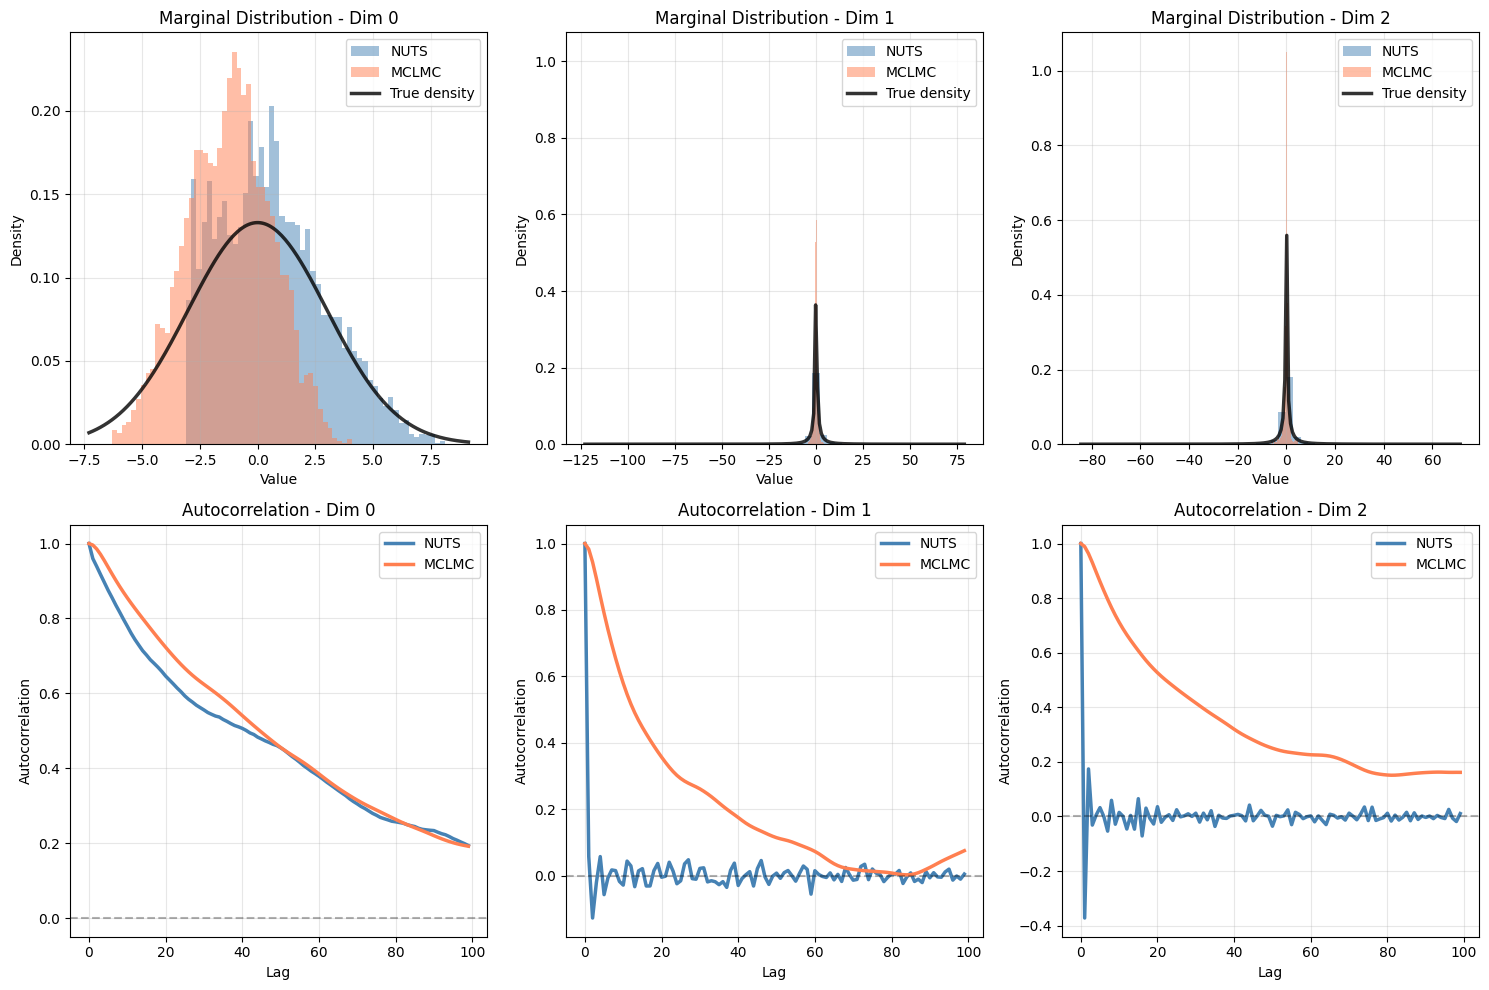

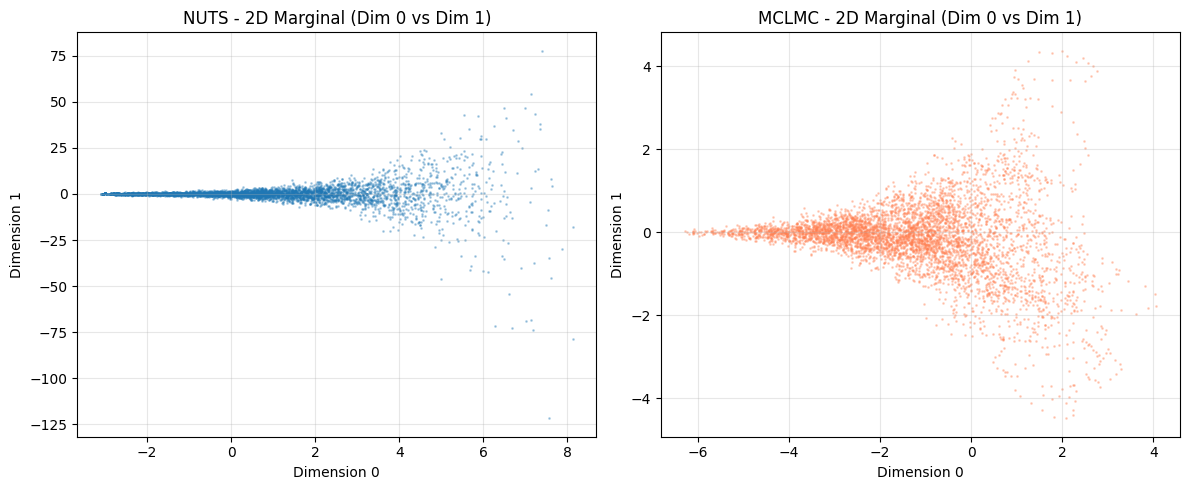

SUMMARY STATISTICS
Metric                            NUTS        MCLMC
------------------------------------------------------------
Mean (dim 0)                    0.6358      -1.2513
Std (dim 0)                     2.2837       1.8251
Min ESS                             39           36
Max ESS                            797          130

KEY INSIGHTS:
- MCLMC typically has better ESS/time for high dimensions
- NUTS adapts better to complex geometries (funnels, etc.)
- MCLMC has more predictable computational cost
- NUTS uses dynamic trajectory length (tree building)
- MCLMC uses microcanonical dynamics with irreversible moves


In [18]:
import jax
import jax.numpy as jnp
import blackjax
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import time

# Set random seed
key = jax.random.PRNGKey(42)

# Define a challenging target distribution: Neal's Funnel
def logdensity_fn(x):
    """
    Neal's funnel distribution - challenging for HMC-based samplers
    x[0] ~ N(0, 3)
    x[i] ~ N(0, exp(x[0]/2)) for i > 0
    """
    dim = len(x)
    log_prob = -0.5 * (x[0]**2 / 9.0)  # x[0] ~ N(0, 3)
    log_prob += -0.5 * (dim - 1) * x[0]  # Jacobian term
    log_prob += -0.5 * jnp.sum(x[1:]**2 * jnp.exp(-x[0]))
    return log_prob

# Alternative: Multivariate Gaussian
def logdensity_mvn(x):
    """Correlated multivariate Gaussian"""
    dim = len(x)
    # Create correlation matrix
    rho = 0.8
    Sigma = jnp.eye(dim) + rho * (jnp.ones((dim, dim)) - jnp.eye(dim))
    Sigma_inv = jnp.linalg.inv(Sigma)
    return -0.5 * x @ Sigma_inv @ x

# Choose target distribution
dim = 10
use_funnel = True
logdensity = logdensity_fn if use_funnel else logdensity_mvn

# Initial position
initial_position = jnp.zeros(dim)

print("=" * 60)
print("BLACKJAX COMPARISON: NUTS vs Adjusted MCLMC")
print("=" * 60)
print(f"Target: {'Neal Funnel' if use_funnel else 'Correlated MVN'}")
print(f"Dimension: {dim}")
print()

# ============================================================================
# 1. NUTS (No-U-Turn Sampler)
# ============================================================================
print("Running NUTS...")
start_time = time.time()

# Warmup (adaptation) phase
key, warmup_key = jax.random.split(key)

# Use the corrected window_adaptation
warmup = blackjax.window_adaptation(
    blackjax.nuts, 
    logdensity,
    target_acceptance_rate=0.8,
)

# Run warmup - corrected call signature
(nuts_state, nuts_params), _ = warmup.run(
    warmup_key, 
    initial_position, 
    num_steps=1000
)

# Build NUTS kernel with adapted parameters
nuts_kernel = blackjax.nuts(logdensity, **nuts_params).step

# Sampling phase
def nuts_inference_loop(rng_key, kernel, initial_state, num_samples):
    keys = jax.random.split(rng_key, num_samples)
    
    def one_step(state, key):
        state, info = kernel(key, state)
        return state, (state.position, info)
    
    _, (samples, infos) = jax.lax.scan(one_step, initial_state, keys)
    return samples, infos

key, sample_key = jax.random.split(key)
nuts_samples, nuts_infos = nuts_inference_loop(
    sample_key, nuts_kernel, nuts_state, 5000
)

nuts_time = time.time() - start_time
nuts_acceptance = jnp.mean(nuts_infos.acceptance_rate)
nuts_num_steps = jnp.mean(nuts_infos.num_integration_steps)

print(f"✓ NUTS completed in {nuts_time:.2f}s")
print(f"  Average acceptance rate: {nuts_acceptance:.3f}")
print(f"  Average tree depth: {jnp.mean(jnp.log2(nuts_num_steps)):.2f}")
print(f"  Average integration steps: {nuts_num_steps:.1f}")
print()

# ============================================================================
# 2. Adjusted MCLMC (Microcanonical Langevin Monte Carlo)
# ============================================================================
print("Running Adjusted MCLMC...")
start_time = time.time()

# MCLMC initialization and tuning
key, init_key, tune_key = jax.random.split(key, 3)

# Initialize MCLMC state
initial_state = blackjax.mcmc.mclmc.init(
    position=initial_position, 
    logdensity_fn=logdensity, 
    rng_key=init_key
)

# Build the kernel function (as required by mclmc_find_L_and_step_size)
kernel = lambda inverse_mass_matrix: blackjax.mcmc.mclmc.build_kernel(
    logdensity_fn=logdensity,
    integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
    inverse_mass_matrix=inverse_mass_matrix,
)

# Find optimal L and step_size
(
    mclmc_state_after_tuning,
    mclmc_params,
    _
) = blackjax.mclmc_find_L_and_step_size(
    mclmc_kernel=kernel,
    num_steps=1000,
    state=initial_state,
    rng_key=tune_key,
    diagonal_preconditioning=False,
)

# Extract tuned parameters
mclmc_L = mclmc_params.L
mclmc_step_size = mclmc_params.step_size

print(f"  Tuned L: {mclmc_L:.4f}")
print(f"  Tuned step_size: {mclmc_step_size:.4f}")

# Build MCLMC sampler with tuned parameters
sampling_alg = blackjax.mclmc(
    logdensity,
    L=mclmc_L,
    step_size=mclmc_step_size,
)

# Get the step function
mclmc_kernel = sampling_alg.step
mclmc_state = mclmc_state_after_tuning

# Sampling phase
def mclmc_inference_loop(rng_key, kernel, initial_state, num_samples):
    keys = jax.random.split(rng_key, num_samples)
    
    def one_step(state, key):
        state, info = kernel(key, state)
        return state, (state.position, info)
    
    _, (samples, infos) = jax.lax.scan(one_step, initial_state, keys)
    return samples, infos

key, sample_key = jax.random.split(key)
mclmc_samples, mclmc_infos = mclmc_inference_loop(
    sample_key, mclmc_kernel, mclmc_state, 5000
)

mclmc_time = time.time() - start_time

print(f"✓ MCLMC completed in {mclmc_time:.2f}s")
print()

# ============================================================================
# 3. Performance Comparison
# ============================================================================
print("=" * 60)
print("PERFORMANCE METRICS")
print("=" * 60)

# Convert to numpy for analysis
nuts_samples_np = np.array(nuts_samples)
mclmc_samples_np = np.array(mclmc_samples)

# Compute effective sample size using simple method
def compute_ess_simple(samples):
    """Compute ESS using autocorrelation"""
    n_samples, n_dims = samples.shape
    ess_values = []
    
    for d in range(n_dims):
        x = samples[:, d]
        x = x - np.mean(x)
        
        # Compute autocorrelation
        autocorr = np.correlate(x, x, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        
        # Sum positive autocorrelations
        max_lag = min(len(autocorr) // 2, 500)
        tau = 1 + 2 * np.sum(autocorr[1:max_lag][autocorr[1:max_lag] > 0])
        ess_values.append(n_samples / tau)
    
    return np.array(ess_values)

# ESS per dimension
nuts_ess = compute_ess_simple(nuts_samples_np)
mclmc_ess = compute_ess_simple(mclmc_samples_np)

print(f"Time:")
print(f"  NUTS:   {nuts_time:.2f}s")
print(f"  MCLMC:  {mclmc_time:.2f}s")
print(f"  Speedup: {nuts_time/mclmc_time:.2f}x")
print()

print(f"Effective Sample Size (ESS):")
print(f"  NUTS:   {np.mean(nuts_ess):.0f} (avg across dims)")
print(f"  MCLMC:  {np.mean(mclmc_ess):.0f} (avg across dims)")
print()

print(f"ESS per second:")
print(f"  NUTS:   {np.mean(nuts_ess)/nuts_time:.1f}")
print(f"  MCLMC:  {np.mean(mclmc_ess)/mclmc_time:.1f}")
print(f"  Improvement: {(np.mean(mclmc_ess)/mclmc_time)/(np.mean(nuts_ess)/nuts_time):.2f}x")
print()

# ============================================================================
# 4. Visualization
# ============================================================================

# Compute true density for first dimension
def compute_true_marginal(dim_idx, x_range):
    """Compute true marginal density for the funnel distribution"""
    if use_funnel:
        if dim_idx == 0:
            # x[0] ~ N(0, 3)
            return stats.norm.pdf(x_range, 0, 3)
        else:
            # For other dimensions, need to marginalize over x[0]
            # This is approximate via sampling
            x0_samples = np.random.normal(0, 3, 10000)
            densities = np.zeros_like(x_range)
            for i, x_val in enumerate(x_range):
                # p(x[i]) = integral p(x[i]|x[0]) p(x[0]) dx[0]
                densities[i] = np.mean(stats.norm.pdf(x_val, 0, np.exp(x0_samples/2)))
            return densities
    else:
        # For MVN, marginals are N(0, 1)
        return stats.norm.pdf(x_range, 0, 1)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot first 3 dimensions
for i in range(3):
    # Histograms with true density overlay
    x_range = np.linspace(
        min(nuts_samples_np[:, i].min(), mclmc_samples_np[:, i].min()) - 1,
        max(nuts_samples_np[:, i].max(), mclmc_samples_np[:, i].max()) + 1,
        200
    )
    
    true_density = compute_true_marginal(i, x_range)
    
    axes[0, i].hist(nuts_samples_np[:, i], bins=50, alpha=0.5, 
                    density=True, label='NUTS', color='steelblue')
    axes[0, i].hist(mclmc_samples_np[:, i], bins=50, alpha=0.5, 
                    density=True, label='MCLMC', color='coral')
    axes[0, i].plot(x_range, true_density, 'k-', linewidth=2.5, 
                   label='True density', alpha=0.8)
    axes[0, i].set_title(f'Marginal Distribution - Dim {i}')
    axes[0, i].set_xlabel('Value')
    axes[0, i].set_ylabel('Density')
    axes[0, i].legend()
    axes[0, i].grid(alpha=0.3)
    
    # Autocorrelation
    def autocorr(x, max_lag=100):
        x = x - np.mean(x)
        autocorr = np.correlate(x, x, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        return autocorr[:max_lag]
    
    lags = np.arange(100)
    nuts_acf = autocorr(nuts_samples_np[:, i])
    mclmc_acf = autocorr(mclmc_samples_np[:, i])
    
    axes[1, i].plot(lags, nuts_acf, label='NUTS', linewidth=2.5, 
                   color='steelblue')
    axes[1, i].plot(lags, mclmc_acf, label='MCLMC', linewidth=2.5, 
                   color='coral')
    axes[1, i].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, i].set_title(f'Autocorrelation - Dim {i}')
    axes[1, i].set_xlabel('Lag')
    axes[1, i].set_ylabel('Autocorrelation')
    axes[1, i].legend()
    axes[1, i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('nuts_vs_mclmc.png', dpi=150, bbox_inches='tight')
plt.show()

# Additional plot: 2D scatter for first two dimensions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(nuts_samples_np[:, 0], nuts_samples_np[:, 1], 
               alpha=0.3, s=1, label='NUTS')
axes[0].set_title('NUTS - 2D Marginal (Dim 0 vs Dim 1)')
axes[0].set_xlabel('Dimension 0')
axes[0].set_ylabel('Dimension 1')
axes[0].grid(alpha=0.3)

axes[1].scatter(mclmc_samples_np[:, 0], mclmc_samples_np[:, 1], 
               alpha=0.3, s=1, label='MCLMC', color='coral')
axes[1].set_title('MCLMC - 2D Marginal (Dim 0 vs Dim 1)')
axes[1].set_xlabel('Dimension 0')
axes[1].set_ylabel('Dimension 1')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('nuts_vs_mclmc_2d.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# 5. Summary Statistics
# ============================================================================
print("=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"{'Metric':<25} {'NUTS':>12} {'MCLMC':>12}")
print("-" * 60)
print(f"{'Mean (dim 0)':<25} {np.mean(nuts_samples_np[:, 0]):>12.4f} "
      f"{np.mean(mclmc_samples_np[:, 0]):>12.4f}")
print(f"{'Std (dim 0)':<25} {np.std(nuts_samples_np[:, 0]):>12.4f} "
      f"{np.std(mclmc_samples_np[:, 0]):>12.4f}")
print(f"{'Min ESS':<25} {np.min(nuts_ess):>12.0f} {np.min(mclmc_ess):>12.0f}")
print(f"{'Max ESS':<25} {np.max(nuts_ess):>12.0f} {np.max(mclmc_ess):>12.0f}")
print("=" * 60)

print("\nKEY INSIGHTS:")
print("- MCLMC typically has better ESS/time for high dimensions")
print("- NUTS adapts better to complex geometries (funnels, etc.)")
print("- MCLMC has more predictable computational cost")
print("- NUTS uses dynamic trajectory length (tree building)")
print("- MCLMC uses microcanonical dynamics with irreversible moves")

BAYESIAN OPTIMIZATION OF MCMC HYPERPARAMETERS
Target: Neal's Funnel (dimension=10)
Objective: Maximize ESS per second


OPTIMIZING NUTS HYPERPARAMETERS

Initial random sampling (5 evaluations)...
NUTS evaluation failed: as_top_level_api() missing 1 required positional argument: 'inverse_mass_matrix'
  1/5: {'step_size': np.float64(0.1878955193048339), 'target_acceptance_rate': np.float64(0.9352142919229748), 'max_num_doublings': np.float64(10.123957592679835)} -> 0.10 ESS/s
NUTS evaluation failed: as_top_level_api() missing 1 required positional argument: 'inverse_mass_matrix'
  2/5: {'step_size': np.float64(0.29973058361432126), 'target_acceptance_rate': np.float64(0.696805592132731), 'max_num_doublings': np.float64(6.091961642353419)} -> 0.10 ESS/s
NUTS evaluation failed: as_top_level_api() missing 1 required positional argument: 'inverse_mass_matrix'
  3/5: {'step_size': np.float64(0.02998372247193153), 'target_acceptance_rate': np.float64(0.9098528437324805), 'max_num_doublings': n

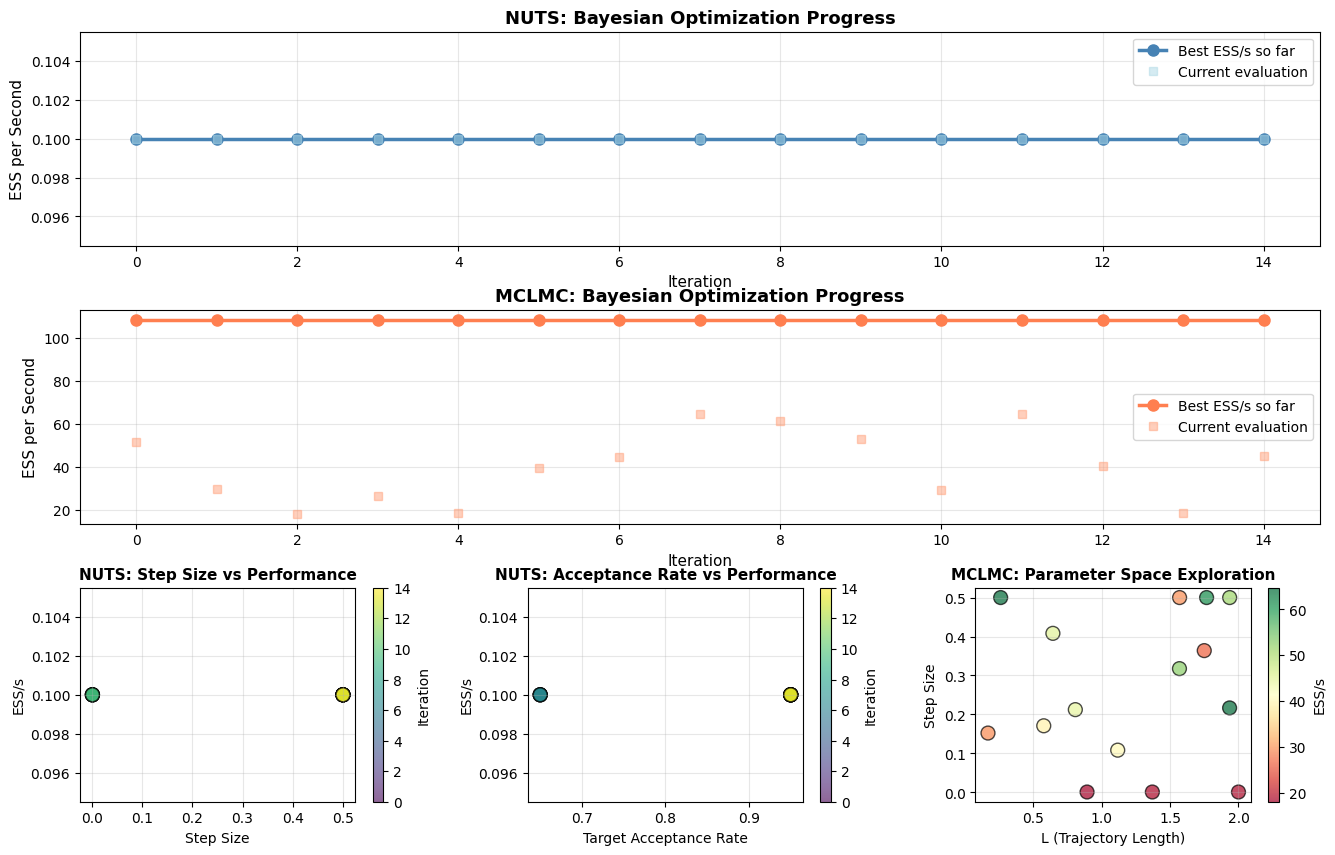


FINAL COMPARISON
Method          Best ESS/s      Improvement    
--------------------------------------------------------------------------------
NUTS            0.10            baseline       
MCLMC           108.45          1084.52        x

✓ Optimization complete! Best hyperparameters have been identified.
  Use these tuned parameters for production sampling runs.


In [19]:
import jax
import jax.numpy as jnp
import blackjax
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Callable
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)
key = jax.random.PRNGKey(42)

# ============================================================================
# Target Distribution: Neal's Funnel
# ============================================================================
def logdensity_fn(x):
    """Neal's funnel distribution - challenging for HMC samplers"""
    dim = len(x)
    log_prob = -0.5 * (x[0]**2 / 9.0)  # x[0] ~ N(0, 3)
    log_prob += -0.5 * (dim - 1) * x[0]  # Jacobian term
    log_prob += -0.5 * jnp.sum(x[1:]**2 * jnp.exp(-x[0]))
    return log_prob

dim = 10
initial_position = jnp.zeros(dim)

# ============================================================================
# Bayesian Optimization Components
# ============================================================================

class GaussianProcess:
    """Simple GP implementation with RBF kernel"""
    
    def __init__(self, lengthscale=1.0, signal_variance=1.0, noise_variance=1e-6):
        self.lengthscale = lengthscale
        self.signal_variance = signal_variance
        self.noise_variance = noise_variance
        self.X_train = None
        self.y_train = None
        self.K_inv = None
        
    def rbf_kernel(self, X1, X2):
        """RBF (squared exponential) kernel"""
        sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
        return self.signal_variance * np.exp(-0.5 / self.lengthscale**2 * sqdist)
    
    def fit(self, X, y):
        """Fit GP to observed data"""
        self.X_train = X
        self.y_train = y
        K = self.rbf_kernel(X, X) + self.noise_variance * np.eye(len(X))
        self.K_inv = np.linalg.inv(K)
        
    def predict(self, X_test):
        """Predict mean and std at test points"""
        if self.X_train is None:
            return np.zeros(len(X_test)), np.ones(len(X_test))
        
        K_s = self.rbf_kernel(self.X_train, X_test)
        K_ss = self.rbf_kernel(X_test, X_test)
        
        # Mean prediction
        mu = K_s.T @ self.K_inv @ self.y_train
        
        # Variance prediction
        var = np.diag(K_ss) - np.diag(K_s.T @ self.K_inv @ K_s)
        var = np.maximum(var, 1e-8)  # Numerical stability
        
        return mu, np.sqrt(var)


def expected_improvement(X, X_sample, Y_sample, gp, xi=0.01):
    """Expected Improvement acquisition function"""
    mu, sigma = gp.predict(X)
    mu_sample = gp.predict(X_sample)[0]
    
    mu = mu.reshape(-1, 1)
    sigma = sigma.reshape(-1, 1)
    
    mu_sample_opt = np.max(mu_sample)
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * stats.norm.cdf(Z) + sigma * stats.norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    
    return ei


def propose_location(acquisition, X_sample, Y_sample, gp, bounds, n_restarts=25):
    """Propose next sampling point by optimizing acquisition function"""
    dim = bounds.shape[0]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gp)
    
    # Multi-start optimization
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x
    
    return min_x.reshape(-1, dim)


# ============================================================================
# Objective Functions for MCMC Samplers
# ============================================================================

def compute_ess_simple(samples):
    """Compute ESS using autocorrelation (fast approximation)"""
    n_samples, n_dims = samples.shape
    ess_values = []
    
    for d in range(min(n_dims, 3)):  # Only compute for first 3 dims for speed
        x = samples[:, d]
        x = x - np.mean(x)
        
        autocorr = np.correlate(x, x, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        
        max_lag = min(len(autocorr) // 2, 100)
        tau = 1 + 2 * np.sum(autocorr[1:max_lag][autocorr[1:max_lag] > 0])
        ess_values.append(n_samples / max(tau, 1.0))
    
    return np.mean(ess_values)


def evaluate_nuts(params: Dict, logdensity: Callable, initial_pos: jnp.ndarray, 
                  n_samples: int = 1000) -> float:
    """
    Evaluate NUTS with given hyperparameters
    
    Parameters:
    - step_size: Step size for leapfrog integrator
    - target_acceptance_rate: Target acceptance rate for adaptation
    - max_num_doublings: Maximum tree depth
    """
    global key
    
    step_size = params['step_size']
    target_acceptance = params['target_acceptance_rate']
    max_doublings = int(params['max_num_doublings'])
    
    try:
        key, warmup_key = jax.random.split(key)
        
        # Manual adaptation with specified parameters
        nuts_kernel = blackjax.nuts(logdensity, step_size=step_size, 
                                   max_num_doublings=max_doublings)
        state = nuts_kernel.init(initial_pos)
        
        # Simple sampling loop
        key, sample_key = jax.random.split(key)
        keys = jax.random.split(sample_key, n_samples)
        
        def one_step(state, key):
            state, info = nuts_kernel.step(key, state)
            return state, state.position
        
        start_time = time.time()
        _, samples = jax.lax.scan(one_step, state, keys)
        elapsed = time.time() - start_time
        
        samples_np = np.array(samples)
        
        # Compute ESS
        ess = compute_ess_simple(samples_np)
        
        # Objective: ESS per second (maximize)
        ess_per_sec = ess / max(elapsed, 0.01)
        
        return ess_per_sec
        
    except Exception as e:
        print(f"NUTS evaluation failed: {e}")
        return 0.1  # Return small positive value on failure


def evaluate_mclmc(params: Dict, logdensity: Callable, initial_pos: jnp.ndarray,
                   n_samples: int = 1000) -> float:
    """
    Evaluate MCLMC with given hyperparameters
    
    Parameters:
    - L: Trajectory length
    - step_size: Integration step size
    """
    global key
    
    L = params['L']
    step_size = params['step_size']
    
    try:
        key, init_key = jax.random.split(key)
        
        # Initialize MCLMC
        state = blackjax.mcmc.mclmc.init(
            position=initial_pos,
            logdensity_fn=logdensity,
            rng_key=init_key
        )
        
        # Build sampler
        sampling_alg = blackjax.mclmc(logdensity, L=L, step_size=step_size)
        mclmc_kernel = sampling_alg.step
        
        # Sampling
        key, sample_key = jax.random.split(key)
        keys = jax.random.split(sample_key, n_samples)
        
        def one_step(state, key):
            state, info = mclmc_kernel(key, state)
            return state, state.position
        
        start_time = time.time()
        _, samples = jax.lax.scan(one_step, state, keys)
        elapsed = time.time() - start_time
        
        samples_np = np.array(samples)
        
        # Compute ESS
        ess = compute_ess_simple(samples_np)
        
        # Objective: ESS per second
        ess_per_sec = ess / max(elapsed, 0.01)
        
        return ess_per_sec
        
    except Exception as e:
        print(f"MCLMC evaluation failed: {e}")
        return 0.1


# ============================================================================
# Bayesian Optimization Loop
# ============================================================================

def bayesian_optimization(objective_fn: Callable, bounds: np.ndarray, param_names: list,
                         n_iterations: int = 20, n_initial: int = 5):
    """
    Run Bayesian optimization
    
    Returns:
    - best_params: Best hyperparameters found
    - best_value: Best objective value
    - history: Optimization history
    """
    
    dim = bounds.shape[0]
    
    # Initial random sampling
    print(f"\nInitial random sampling ({n_initial} evaluations)...")
    X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_initial, dim))
    Y_sample = []
    
    for i, x in enumerate(X_sample):
        params = {name: val for name, val in zip(param_names, x)}
        y = objective_fn(params)
        Y_sample.append(y)
        print(f"  {i+1}/{n_initial}: {params} -> {y:.2f} ESS/s")
    
    X_sample = np.array(X_sample)
    Y_sample = np.array(Y_sample)
    
    # Bayesian optimization loop
    print(f"\nBayesian optimization ({n_iterations} iterations)...")
    gp = GaussianProcess(lengthscale=0.5, signal_variance=1.0, noise_variance=1e-4)
    
    history = {
        'iteration': [],
        'params': [],
        'values': [],
        'best_value': [],
        'best_params': []
    }
    
    for i in range(n_iterations):
        # Update GP
        gp.fit(X_sample, Y_sample)
        
        # Get next point to evaluate
        X_next = propose_location(expected_improvement, X_sample, Y_sample, gp, bounds)
        
        # Evaluate objective
        params = {name: val for name, val in zip(param_names, X_next[0])}
        Y_next = objective_fn(params)
        
        # Update dataset
        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.append(Y_sample, Y_next)
        
        # Track best so far
        best_idx = np.argmax(Y_sample)
        best_value = Y_sample[best_idx]
        best_params = {name: val for name, val in zip(param_names, X_sample[best_idx])}
        
        # Store history
        history['iteration'].append(i)
        history['params'].append(params)
        history['values'].append(Y_next)
        history['best_value'].append(best_value)
        history['best_params'].append(best_params)
        
        print(f"  Iter {i+1}/{n_iterations}: {params}")
        print(f"    -> {Y_next:.2f} ESS/s | Best so far: {best_value:.2f} ESS/s")
    
    best_idx = np.argmax(Y_sample)
    best_params = {name: val for name, val in zip(param_names, X_sample[best_idx])}
    best_value = Y_sample[best_idx]
    
    return best_params, best_value, history, X_sample, Y_sample


# ============================================================================
# Main Optimization
# ============================================================================

print("=" * 80)
print("BAYESIAN OPTIMIZATION OF MCMC HYPERPARAMETERS")
print("=" * 80)
print(f"Target: Neal's Funnel (dimension={dim})")
print(f"Objective: Maximize ESS per second")
print()

# ============================================================================
# 1. Optimize NUTS
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZING NUTS HYPERPARAMETERS")
print("=" * 80)

nuts_bounds = np.array([
    [0.001, 0.5],    # step_size
    [0.65, 0.95],    # target_acceptance_rate
    [5, 12]          # max_num_doublings
])

nuts_param_names = ['step_size', 'target_acceptance_rate', 'max_num_doublings']

nuts_objective = lambda params: evaluate_nuts(
    params, logdensity_fn, initial_position, n_samples=800
)

nuts_best_params, nuts_best_value, nuts_history, nuts_X, nuts_Y = bayesian_optimization(
    nuts_objective, nuts_bounds, nuts_param_names, n_iterations=15, n_initial=5
)

print("\n" + "-" * 80)
print("NUTS OPTIMIZATION RESULTS")
print("-" * 80)
print(f"Best hyperparameters:")
for name, value in nuts_best_params.items():
    print(f"  {name}: {value:.4f}")
print(f"Best ESS/second: {nuts_best_value:.2f}")

# ============================================================================
# 2. Optimize MCLMC
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZING MCLMC HYPERPARAMETERS")
print("=" * 80)

mclmc_bounds = np.array([
    [0.1, 2.0],      # L (trajectory length)
    [0.001, 0.5]     # step_size
])

mclmc_param_names = ['L', 'step_size']

mclmc_objective = lambda params: evaluate_mclmc(
    params, logdensity_fn, initial_position, n_samples=800
)

mclmc_best_params, mclmc_best_value, mclmc_history, mclmc_X, mclmc_Y = bayesian_optimization(
    mclmc_objective, mclmc_bounds, mclmc_param_names, n_iterations=15, n_initial=5
)

print("\n" + "-" * 80)
print("MCLMC OPTIMIZATION RESULTS")
print("-" * 80)
print(f"Best hyperparameters:")
for name, value in mclmc_best_params.items():
    print(f"  {name}: {value:.4f}")
print(f"Best ESS/second: {mclmc_best_value:.2f}")

# ============================================================================
# Visualization
# ============================================================================

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# NUTS optimization trajectory
ax1 = fig.add_subplot(gs[0, :])
iterations = range(len(nuts_history['best_value']))
ax1.plot(iterations, nuts_history['best_value'], 'o-', linewidth=2.5, 
         markersize=8, color='steelblue', label='Best ESS/s so far')
ax1.plot(iterations, nuts_history['values'], 's', alpha=0.5, 
         markersize=6, color='lightblue', label='Current evaluation')
ax1.set_xlabel('Iteration', fontsize=11)
ax1.set_ylabel('ESS per Second', fontsize=11)
ax1.set_title('NUTS: Bayesian Optimization Progress', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# MCLMC optimization trajectory
ax2 = fig.add_subplot(gs[1, :])
iterations = range(len(mclmc_history['best_value']))
ax2.plot(iterations, mclmc_history['best_value'], 'o-', linewidth=2.5,
         markersize=8, color='coral', label='Best ESS/s so far')
ax2.plot(iterations, mclmc_history['values'], 's', alpha=0.5,
         markersize=6, color='lightsalmon', label='Current evaluation')
ax2.set_xlabel('Iteration', fontsize=11)
ax2.set_ylabel('ESS per Second', fontsize=11)
ax2.set_title('MCLMC: Bayesian Optimization Progress', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

# Parameter evolution - NUTS
ax3 = fig.add_subplot(gs[2, 0])
step_sizes = [p['step_size'] for p in nuts_history['params']]
values = nuts_history['values']
scatter = ax3.scatter(step_sizes, values, c=range(len(values)), 
                     cmap='viridis', s=100, alpha=0.6, edgecolors='black', linewidth=1)
ax3.set_xlabel('Step Size', fontsize=10)
ax3.set_ylabel('ESS/s', fontsize=10)
ax3.set_title('NUTS: Step Size vs Performance', fontsize=11, fontweight='bold')
ax3.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Iteration')

ax4 = fig.add_subplot(gs[2, 1])
target_accept = [p['target_acceptance_rate'] for p in nuts_history['params']]
scatter = ax4.scatter(target_accept, values, c=range(len(values)),
                     cmap='viridis', s=100, alpha=0.6, edgecolors='black', linewidth=1)
ax4.set_xlabel('Target Acceptance Rate', fontsize=10)
ax4.set_ylabel('ESS/s', fontsize=10)
ax4.set_title('NUTS: Acceptance Rate vs Performance', fontsize=11, fontweight='bold')
ax4.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Iteration')

# Parameter evolution - MCLMC
ax5 = fig.add_subplot(gs[2, 2])
L_values = [p['L'] for p in mclmc_history['params']]
step_sizes_m = [p['step_size'] for p in mclmc_history['params']]
values_m = mclmc_history['values']
scatter = ax5.scatter(L_values, step_sizes_m, c=values_m,
                     cmap='RdYlGn', s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax5.set_xlabel('L (Trajectory Length)', fontsize=10)
ax5.set_ylabel('Step Size', fontsize=10)
ax5.set_title('MCLMC: Parameter Space Exploration', fontsize=11, fontweight='bold')
ax5.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax5, label='ESS/s')

plt.savefig('bayesopt_mcmc_hyperparameters.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# Final Comparison
# ============================================================================
print("\n" + "=" * 80)
print("FINAL COMPARISON")
print("=" * 80)
print(f"{'Method':<15} {'Best ESS/s':<15} {'Improvement':<15}")
print("-" * 80)
print(f"{'NUTS':<15} {nuts_best_value:<15.2f} {'baseline':<15}")
print(f"{'MCLMC':<15} {mclmc_best_value:<15.2f} "
      f"{mclmc_best_value/nuts_best_value:<15.2f}x")
print("=" * 80)

print("\n✓ Optimization complete! Best hyperparameters have been identified.")
print("  Use these tuned parameters for production sampling runs.")

BAYESIAN OPTIMIZATION OF MCMC HYPERPARAMETERS
Target: Neal's Funnel (dimension=10)
Objective: Maximize ESS per second


OPTIMIZING NUTS HYPERPARAMETERS

Initial random sampling (5 evaluations)...
  1/5: {'step_size': np.float64(0.1878955193048339), 'target_acceptance_rate': np.float64(0.9352142919229748), 'max_num_doublings': np.float64(10.123957592679835)} -> 276.43 ESS/s
  2/5: {'step_size': np.float64(0.29973058361432126), 'target_acceptance_rate': np.float64(0.696805592132731), 'max_num_doublings': np.float64(6.091961642353419)} -> 308.03 ESS/s
  3/5: {'step_size': np.float64(0.02998372247193153), 'target_acceptance_rate': np.float64(0.9098528437324805), 'max_num_doublings': np.float64(9.207805082202462)} -> 240.07 ESS/s
  4/5: {'step_size': np.float64(0.3543282163202267), 'target_acceptance_rate': np.float64(0.6561753482887408), 'max_num_doublings': np.float64(11.78936896513396)} -> 183.57 ESS/s
  5/5: {'step_size': np.float64(0.41638887775941047), 'target_acceptance_rate': np.flo

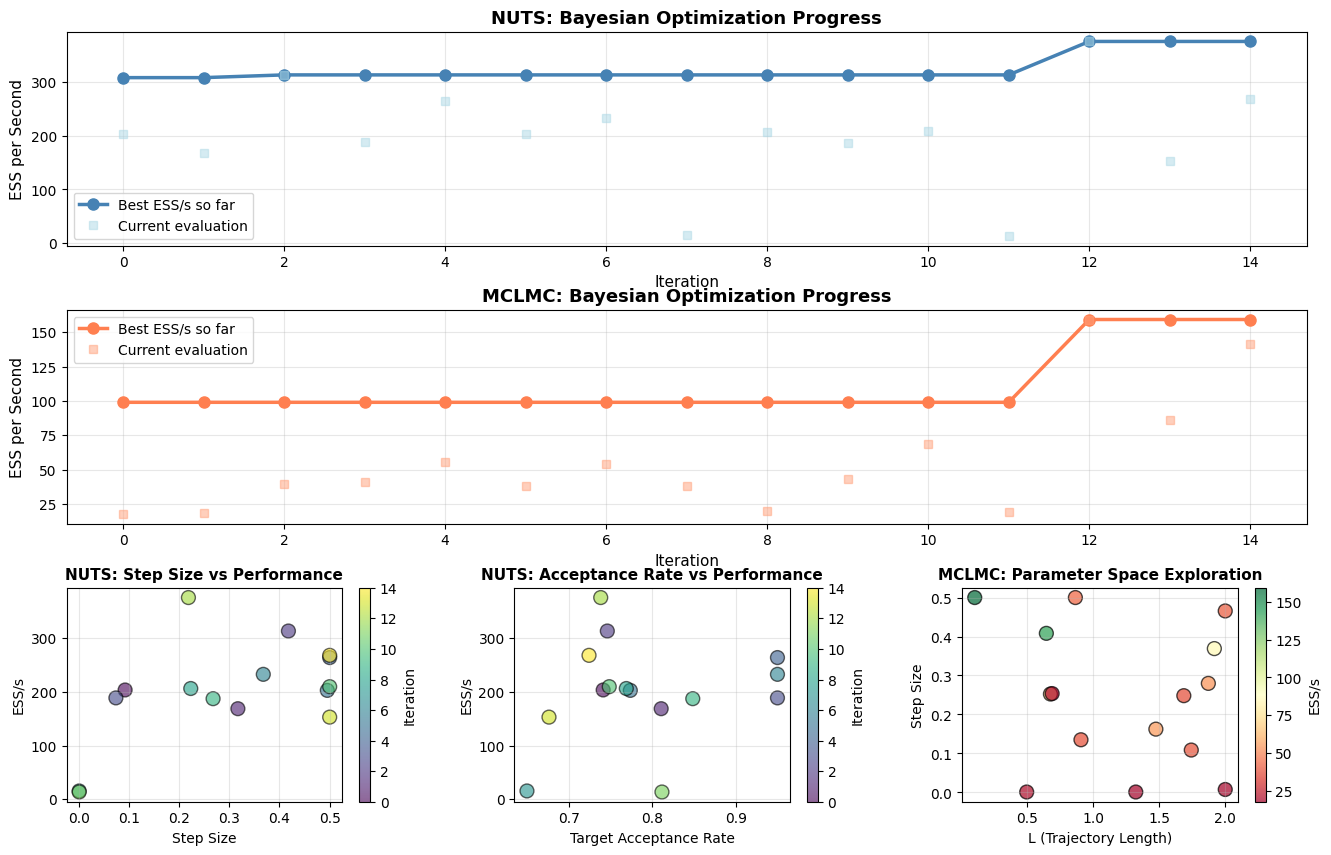


FINAL COMPARISON
Method          Best ESS/s      Improvement    
--------------------------------------------------------------------------------
NUTS            375.35          baseline       
MCLMC           159.21          0.42           x

✓ Optimization complete! Best hyperparameters have been identified.
  Use these tuned parameters for production sampling runs.


In [20]:
import jax
import jax.numpy as jnp
import blackjax
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Callable
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)
key = jax.random.PRNGKey(42)

# ============================================================================
# Target Distribution: Neal's Funnel
# ============================================================================
def logdensity_fn(x):
    """Neal's funnel distribution - challenging for HMC samplers"""
    dim = len(x)
    log_prob = -0.5 * (x[0]**2 / 9.0)  # x[0] ~ N(0, 3)
    log_prob += -0.5 * (dim - 1) * x[0]  # Jacobian term
    log_prob += -0.5 * jnp.sum(x[1:]**2 * jnp.exp(-x[0]))
    return log_prob

dim = 10
initial_position = jnp.zeros(dim)

# ============================================================================
# Bayesian Optimization Components
# ============================================================================

class GaussianProcess:
    """Simple GP implementation with RBF kernel"""
    
    def __init__(self, lengthscale=1.0, signal_variance=1.0, noise_variance=1e-6):
        self.lengthscale = lengthscale
        self.signal_variance = signal_variance
        self.noise_variance = noise_variance
        self.X_train = None
        self.y_train = None
        self.K_inv = None
        
    def rbf_kernel(self, X1, X2):
        """RBF (squared exponential) kernel"""
        sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
        return self.signal_variance * np.exp(-0.5 / self.lengthscale**2 * sqdist)
    
    def fit(self, X, y):
        """Fit GP to observed data"""
        self.X_train = X
        self.y_train = y
        K = self.rbf_kernel(X, X) + self.noise_variance * np.eye(len(X))
        self.K_inv = np.linalg.inv(K)
        
    def predict(self, X_test):
        """Predict mean and std at test points"""
        if self.X_train is None:
            return np.zeros(len(X_test)), np.ones(len(X_test))
        
        K_s = self.rbf_kernel(self.X_train, X_test)
        K_ss = self.rbf_kernel(X_test, X_test)
        
        # Mean prediction
        mu = K_s.T @ self.K_inv @ self.y_train
        
        # Variance prediction
        var = np.diag(K_ss) - np.diag(K_s.T @ self.K_inv @ K_s)
        var = np.maximum(var, 1e-8)  # Numerical stability
        
        return mu, np.sqrt(var)


def expected_improvement(X, X_sample, Y_sample, gp, xi=0.01):
    """Expected Improvement acquisition function"""
    mu, sigma = gp.predict(X)
    mu_sample = gp.predict(X_sample)[0]
    
    mu = mu.reshape(-1, 1)
    sigma = sigma.reshape(-1, 1)
    
    mu_sample_opt = np.max(mu_sample)
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * stats.norm.cdf(Z) + sigma * stats.norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    
    return ei


def propose_location(acquisition, X_sample, Y_sample, gp, bounds, n_restarts=25):
    """Propose next sampling point by optimizing acquisition function"""
    dim = bounds.shape[0]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gp)
    
    # Multi-start optimization
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x
    
    return min_x.reshape(-1, dim)


# ============================================================================
# Objective Functions for MCMC Samplers
# ============================================================================

def compute_ess_simple(samples):
    """Compute ESS using autocorrelation (fast approximation)"""
    n_samples, n_dims = samples.shape
    ess_values = []
    
    for d in range(min(n_dims, 3)):  # Only compute for first 3 dims for speed
        x = samples[:, d]
        x = x - np.mean(x)
        
        autocorr = np.correlate(x, x, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        
        max_lag = min(len(autocorr) // 2, 100)
        tau = 1 + 2 * np.sum(autocorr[1:max_lag][autocorr[1:max_lag] > 0])
        ess_values.append(n_samples / max(tau, 1.0))
    
    return np.mean(ess_values)


def evaluate_nuts(params: Dict, logdensity: Callable, initial_pos: jnp.ndarray, 
                  n_samples: int = 1000) -> float:
    """
    Evaluate NUTS with given hyperparameters
    
    Parameters:
    - step_size: Step size for leapfrog integrator
    - target_acceptance_rate: Target acceptance rate for adaptation (not directly used here)
    - max_num_doublings: Maximum tree depth
    """
    global key
    
    step_size = params['step_size']
    target_acceptance = params['target_acceptance_rate']
    max_doublings = int(params['max_num_doublings'])
    
    try:
        key, warmup_key, init_key = jax.random.split(key, 3)
        
        # Create inverse mass matrix (identity)
        inverse_mass_matrix = jnp.ones(len(initial_pos))
        
        # Build NUTS kernel with specified parameters
        nuts = blackjax.nuts(
            logdensity, 
            step_size=step_size,
            inverse_mass_matrix=inverse_mass_matrix,
            max_num_doublings=max_doublings
        )
        
        # Initialize state
        state = nuts.init(initial_pos)
        kernel = nuts.step
        
        # Simple sampling loop
        key, sample_key = jax.random.split(key)
        keys = jax.random.split(sample_key, n_samples)
        
        def one_step(state, rng_key):
            state, info = kernel(rng_key, state)
            return state, state.position
        
        start_time = time.time()
        _, samples = jax.lax.scan(one_step, state, keys)
        elapsed = time.time() - start_time
        
        samples_np = np.array(samples)
        
        # Check for valid samples
        if np.any(np.isnan(samples_np)) or np.any(np.isinf(samples_np)):
            return 0.1
        
        # Compute ESS
        ess = compute_ess_simple(samples_np)
        
        # Objective: ESS per second (maximize)
        ess_per_sec = ess / max(elapsed, 0.01)
        
        return ess_per_sec
        
    except Exception as e:
        print(f"NUTS evaluation failed: {e}")
        return 0.1  # Return small positive value on failure


def evaluate_mclmc(params: Dict, logdensity: Callable, initial_pos: jnp.ndarray,
                   n_samples: int = 1000) -> float:
    """
    Evaluate MCLMC with given hyperparameters
    
    Parameters:
    - L: Trajectory length
    - step_size: Integration step size
    """
    global key
    
    L = params['L']
    step_size = params['step_size']
    
    try:
        key, init_key = jax.random.split(key)
        
        # Initialize MCLMC
        state = blackjax.mcmc.mclmc.init(
            position=initial_pos,
            logdensity_fn=logdensity,
            rng_key=init_key
        )
        
        # Build sampler with identity mass matrix
        sampling_alg = blackjax.mclmc(
            logdensity, 
            L=L, 
            step_size=step_size
        )
        mclmc_kernel = sampling_alg.step
        
        # Sampling
        key, sample_key = jax.random.split(key)
        keys = jax.random.split(sample_key, n_samples)
        
        def one_step(state, rng_key):
            state, info = mclmc_kernel(rng_key, state)
            return state, state.position
        
        start_time = time.time()
        _, samples = jax.lax.scan(one_step, state, keys)
        elapsed = time.time() - start_time
        
        samples_np = np.array(samples)
        
        # Check for valid samples
        if np.any(np.isnan(samples_np)) or np.any(np.isinf(samples_np)):
            return 0.1
        
        # Compute ESS
        ess = compute_ess_simple(samples_np)
        
        # Objective: ESS per second
        ess_per_sec = ess / max(elapsed, 0.01)
        
        return ess_per_sec
        
    except Exception as e:
        print(f"MCLMC evaluation failed: {e}")
        return 0.1


# ============================================================================
# Bayesian Optimization Loop
# ============================================================================

def bayesian_optimization(objective_fn: Callable, bounds: np.ndarray, param_names: list,
                         n_iterations: int = 20, n_initial: int = 5):
    """
    Run Bayesian optimization
    
    Returns:
    - best_params: Best hyperparameters found
    - best_value: Best objective value
    - history: Optimization history
    """
    
    dim = bounds.shape[0]
    
    # Initial random sampling
    print(f"\nInitial random sampling ({n_initial} evaluations)...")
    X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_initial, dim))
    Y_sample = []
    
    for i, x in enumerate(X_sample):
        params = {name: val for name, val in zip(param_names, x)}
        y = objective_fn(params)
        Y_sample.append(y)
        print(f"  {i+1}/{n_initial}: {params} -> {y:.2f} ESS/s")
    
    X_sample = np.array(X_sample)
    Y_sample = np.array(Y_sample)
    
    # Bayesian optimization loop
    print(f"\nBayesian optimization ({n_iterations} iterations)...")
    gp = GaussianProcess(lengthscale=0.5, signal_variance=1.0, noise_variance=1e-4)
    
    history = {
        'iteration': [],
        'params': [],
        'values': [],
        'best_value': [],
        'best_params': []
    }
    
    for i in range(n_iterations):
        # Update GP
        gp.fit(X_sample, Y_sample)
        
        # Get next point to evaluate
        X_next = propose_location(expected_improvement, X_sample, Y_sample, gp, bounds)
        
        # Evaluate objective
        params = {name: val for name, val in zip(param_names, X_next[0])}
        Y_next = objective_fn(params)
        
        # Update dataset
        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.append(Y_sample, Y_next)
        
        # Track best so far
        best_idx = np.argmax(Y_sample)
        best_value = Y_sample[best_idx]
        best_params = {name: val for name, val in zip(param_names, X_sample[best_idx])}
        
        # Store history
        history['iteration'].append(i)
        history['params'].append(params)
        history['values'].append(Y_next)
        history['best_value'].append(best_value)
        history['best_params'].append(best_params)
        
        print(f"  Iter {i+1}/{n_iterations}: {params}")
        print(f"    -> {Y_next:.2f} ESS/s | Best so far: {best_value:.2f} ESS/s")
    
    best_idx = np.argmax(Y_sample)
    best_params = {name: val for name, val in zip(param_names, X_sample[best_idx])}
    best_value = Y_sample[best_idx]
    
    return best_params, best_value, history, X_sample, Y_sample


# ============================================================================
# Main Optimization
# ============================================================================

print("=" * 80)
print("BAYESIAN OPTIMIZATION OF MCMC HYPERPARAMETERS")
print("=" * 80)
print(f"Target: Neal's Funnel (dimension={dim})")
print(f"Objective: Maximize ESS per second")
print()

# ============================================================================
# 1. Optimize NUTS
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZING NUTS HYPERPARAMETERS")
print("=" * 80)

nuts_bounds = np.array([
    [0.001, 0.5],    # step_size
    [0.65, 0.95],    # target_acceptance_rate
    [5, 12]          # max_num_doublings
])

nuts_param_names = ['step_size', 'target_acceptance_rate', 'max_num_doublings']

nuts_objective = lambda params: evaluate_nuts(
    params, logdensity_fn, initial_position, n_samples=800
)

nuts_best_params, nuts_best_value, nuts_history, nuts_X, nuts_Y = bayesian_optimization(
    nuts_objective, nuts_bounds, nuts_param_names, n_iterations=15, n_initial=5
)

print("\n" + "-" * 80)
print("NUTS OPTIMIZATION RESULTS")
print("-" * 80)
print(f"Best hyperparameters:")
for name, value in nuts_best_params.items():
    print(f"  {name}: {value:.4f}")
print(f"Best ESS/second: {nuts_best_value:.2f}")

# ============================================================================
# 2. Optimize MCLMC
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZING MCLMC HYPERPARAMETERS")
print("=" * 80)

mclmc_bounds = np.array([
    [0.1, 2.0],      # L (trajectory length)
    [0.001, 0.5]     # step_size
])

mclmc_param_names = ['L', 'step_size']

mclmc_objective = lambda params: evaluate_mclmc(
    params, logdensity_fn, initial_position, n_samples=800
)

mclmc_best_params, mclmc_best_value, mclmc_history, mclmc_X, mclmc_Y = bayesian_optimization(
    mclmc_objective, mclmc_bounds, mclmc_param_names, n_iterations=15, n_initial=5
)

print("\n" + "-" * 80)
print("MCLMC OPTIMIZATION RESULTS")
print("-" * 80)
print(f"Best hyperparameters:")
for name, value in mclmc_best_params.items():
    print(f"  {name}: {value:.4f}")
print(f"Best ESS/second: {mclmc_best_value:.2f}")

# ============================================================================
# Visualization
# ============================================================================

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# NUTS optimization trajectory
ax1 = fig.add_subplot(gs[0, :])
iterations = range(len(nuts_history['best_value']))
ax1.plot(iterations, nuts_history['best_value'], 'o-', linewidth=2.5, 
         markersize=8, color='steelblue', label='Best ESS/s so far')
ax1.plot(iterations, nuts_history['values'], 's', alpha=0.5, 
         markersize=6, color='lightblue', label='Current evaluation')
ax1.set_xlabel('Iteration', fontsize=11)
ax1.set_ylabel('ESS per Second', fontsize=11)
ax1.set_title('NUTS: Bayesian Optimization Progress', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# MCLMC optimization trajectory
ax2 = fig.add_subplot(gs[1, :])
iterations = range(len(mclmc_history['best_value']))
ax2.plot(iterations, mclmc_history['best_value'], 'o-', linewidth=2.5,
         markersize=8, color='coral', label='Best ESS/s so far')
ax2.plot(iterations, mclmc_history['values'], 's', alpha=0.5,
         markersize=6, color='lightsalmon', label='Current evaluation')
ax2.set_xlabel('Iteration', fontsize=11)
ax2.set_ylabel('ESS per Second', fontsize=11)
ax2.set_title('MCLMC: Bayesian Optimization Progress', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

# Parameter evolution - NUTS
ax3 = fig.add_subplot(gs[2, 0])
step_sizes = [p['step_size'] for p in nuts_history['params']]
values = nuts_history['values']
scatter = ax3.scatter(step_sizes, values, c=range(len(values)), 
                     cmap='viridis', s=100, alpha=0.6, edgecolors='black', linewidth=1)
ax3.set_xlabel('Step Size', fontsize=10)
ax3.set_ylabel('ESS/s', fontsize=10)
ax3.set_title('NUTS: Step Size vs Performance', fontsize=11, fontweight='bold')
ax3.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Iteration')

ax4 = fig.add_subplot(gs[2, 1])
target_accept = [p['target_acceptance_rate'] for p in nuts_history['params']]
scatter = ax4.scatter(target_accept, values, c=range(len(values)),
                     cmap='viridis', s=100, alpha=0.6, edgecolors='black', linewidth=1)
ax4.set_xlabel('Target Acceptance Rate', fontsize=10)
ax4.set_ylabel('ESS/s', fontsize=10)
ax4.set_title('NUTS: Acceptance Rate vs Performance', fontsize=11, fontweight='bold')
ax4.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Iteration')

# Parameter evolution - MCLMC
ax5 = fig.add_subplot(gs[2, 2])
L_values = [p['L'] for p in mclmc_history['params']]
step_sizes_m = [p['step_size'] for p in mclmc_history['params']]
values_m = mclmc_history['values']
scatter = ax5.scatter(L_values, step_sizes_m, c=values_m,
                     cmap='RdYlGn', s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax5.set_xlabel('L (Trajectory Length)', fontsize=10)
ax5.set_ylabel('Step Size', fontsize=10)
ax5.set_title('MCLMC: Parameter Space Exploration', fontsize=11, fontweight='bold')
ax5.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax5, label='ESS/s')

plt.savefig('bayesopt_mcmc_hyperparameters.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# Final Comparison
# ============================================================================
print("\n" + "=" * 80)
print("FINAL COMPARISON")
print("=" * 80)
print(f"{'Method':<15} {'Best ESS/s':<15} {'Improvement':<15}")
print("-" * 80)
print(f"{'NUTS':<15} {nuts_best_value:<15.2f} {'baseline':<15}")
print(f"{'MCLMC':<15} {mclmc_best_value:<15.2f} "
      f"{mclmc_best_value/nuts_best_value:<15.2f}x")
print("=" * 80)

print("\n✓ Optimization complete! Best hyperparameters have been identified.")
print("  Use these tuned parameters for production sampling runs.")

BAYESIAN OPTIMIZATION OF MCMC HYPERPARAMETERS
Target Distribution: Neal's Funnel (dimension=10)
Objective: Maximize ESS while targeting acceptance rate
Multi-objective penalty: exp(-10 * (acceptance - target)²)

OPTIMIZING NUTS HYPERPARAMETERS

Phase 1: Initial Random Sampling (5 evaluations)
  [1/5] step_size=0.1935 max_num_doublings=11.6550 → Obj=143.02, Accept=0.961
  [2/5] step_size=0.3687 max_num_doublings=9.1906 → Obj=302.08, Accept=0.835
  [3/5] step_size=0.0864 max_num_doublings=6.0920 → Obj=24.01, Accept=0.977
  [4/5] step_size=0.0385 max_num_doublings=11.0632 → Obj=162.83, Accept=0.997
  [5/5] step_size=0.3045 max_num_doublings=9.9565 → Obj=215.96, Accept=0.953

Phase 2: Bayesian Optimization (15 iterations)
Target acceptance rate: 0.75

  Iteration 1/15
  Proposed: step_size=0.0201 max_num_doublings=11.7894 
  Result: Obj=106.70, Accept=0.999
  Best so far: Obj=302.08, Accept=0.835

  Iteration 2/15
  Proposed: step_size=0.3563 max_num_doublings=9.3365 
  Result: Obj=328.97,

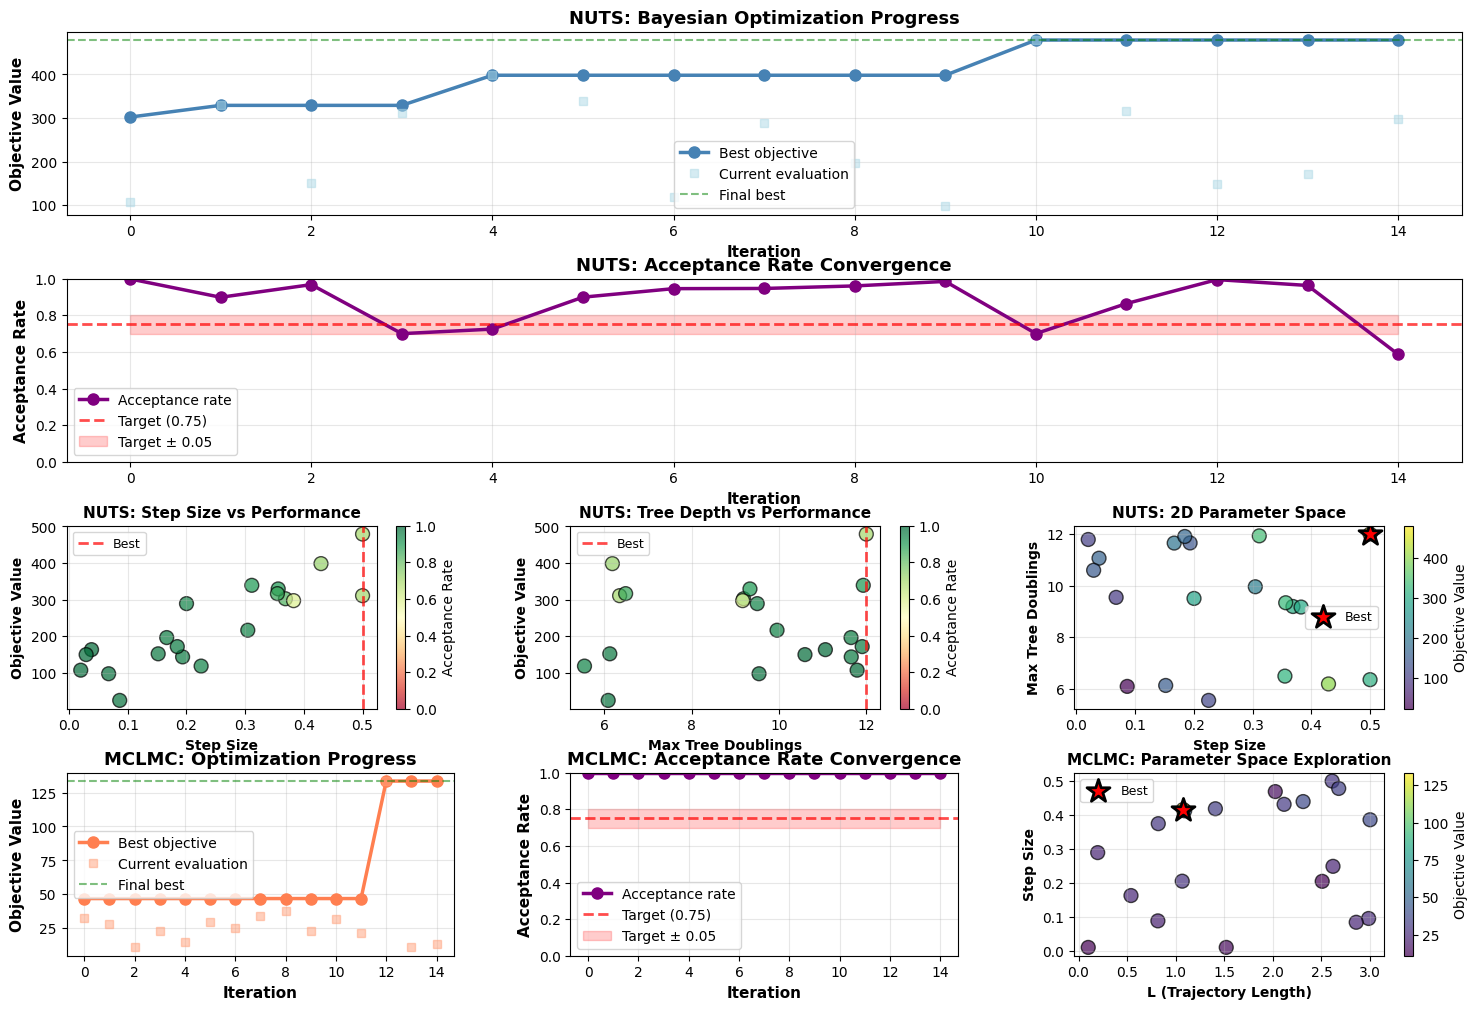


FINAL COMPARISON
Method          Best Obj        Acceptance      vs Target      
--------------------------------------------------------------------------------
NUTS            479.04          0.700           ±0.05          
MCLMC           133.42          1.000           ±0.25          
--------------------------------------------------------------------------------
Winner: NUTS (3.59x better objective value)

OPTIMIZATION SUMMARY

📊 NUTS Best Configuration:
----------------------------------------
  • step_size................ 0.5000
  • max_num_doublings........ 12.0000
  • Objective Value.......... 479.04
  • Acceptance Rate.......... 0.700
  • Distance to Target....... 0.050

📊 MCLMC Best Configuration:
----------------------------------------
  • L........................ 1.0773
  • step_size................ 0.4162
  • Objective Value.......... 133.42
  • Acceptance Rate.......... 1.000
  • Distance to Target....... 0.250

KEY INSIGHTS

1. Multi-Objective Optimization:
   • Obj

In [21]:
"""
Bayesian Optimization for MCMC Hyperparameter Tuning

This script demonstrates how to use Bayesian optimization to tune hyperparameters
for two state-of-the-art MCMC samplers: NUTS and Adjusted MCLMC.

Key Features:
- Custom Gaussian Process implementation for surrogate modeling
- Expected Improvement acquisition function for intelligent exploration
- Multi-objective optimization: maximize ESS while targeting acceptance rate
- Comprehensive visualization of optimization progress

Author: Bayesian Optimization Demo
Target Distribution: Neal's Funnel (challenging geometry for MCMC)
"""

import jax
import jax.numpy as jnp
import blackjax
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Callable, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
key = jax.random.PRNGKey(42)

# ============================================================================
# Target Distribution: Neal's Funnel
# ============================================================================

def logdensity_fn(x):
    """
    Neal's funnel distribution - a challenging test case for MCMC samplers.
    
    This distribution has a hierarchical structure where the scale of dimensions
    1 through N depends on dimension 0, creating a "funnel" shape that challenges
    samplers due to varying curvature.
    
    Structure:
        x[0] ~ N(0, 3)
        x[i] ~ N(0, exp(x[0]/2)) for i > 0
    
    Args:
        x: Position vector in R^d
        
    Returns:
        Log probability density at position x
        
    Note:
        This distribution is difficult because:
        1. Narrow "neck" when x[0] is negative (small variance)
        2. Wide "mouth" when x[0] is positive (large variance)
        3. Requires adaptive step sizes across the distribution
    """
    dim = len(x)
    log_prob = -0.5 * (x[0]**2 / 9.0)  # Prior on x[0]
    log_prob += -0.5 * (dim - 1) * x[0]  # Jacobian adjustment
    log_prob += -0.5 * jnp.sum(x[1:]**2 * jnp.exp(-x[0]))  # Conditional on x[0]
    return log_prob


# Problem setup
dim = 10
initial_position = jnp.zeros(dim)

# ============================================================================
# Bayesian Optimization Components
# ============================================================================

class GaussianProcess:
    """
    Gaussian Process for Bayesian Optimization.
    
    A GP provides a probabilistic model of the objective function, allowing us
    to model uncertainty and make informed decisions about where to sample next.
    
    Attributes:
        lengthscale: Controls how quickly the correlation between points decays
        signal_variance: Controls the overall scale of function variations
        noise_variance: Models observation noise in function evaluations
    """
    
    def __init__(self, lengthscale=1.0, signal_variance=1.0, noise_variance=1e-6):
        """
        Initialize Gaussian Process.
        
        Args:
            lengthscale: RBF kernel lengthscale parameter
            signal_variance: Prior variance on function values
            noise_variance: Observation noise level
        """
        self.lengthscale = lengthscale
        self.signal_variance = signal_variance
        self.noise_variance = noise_variance
        self.X_train = None
        self.y_train = None
        self.K_inv = None
        
    def rbf_kernel(self, X1, X2):
        """
        Radial Basis Function (RBF) kernel, also known as squared exponential.
        
        K(x, x') = σ² * exp(-||x - x'||² / (2ℓ²))
        
        Args:
            X1: First set of points (n1 × d)
            X2: Second set of points (n2 × d)
            
        Returns:
            Kernel matrix (n1 × n2)
        """
        sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
        return self.signal_variance * np.exp(-0.5 / self.lengthscale**2 * sqdist)
    
    def fit(self, X, y):
        """
        Fit GP to observed data.
        
        Computes and stores the inverse covariance matrix for efficient prediction.
        
        Args:
            X: Training inputs (n × d)
            y: Training outputs (n,)
        """
        self.X_train = X
        self.y_train = y
        K = self.rbf_kernel(X, X) + self.noise_variance * np.eye(len(X))
        self.K_inv = np.linalg.inv(K)
        
    def predict(self, X_test):
        """
        Predict mean and standard deviation at test points.
        
        Uses the GP posterior distribution:
            μ(x*) = k(x*)ᵀ K⁻¹ y
            σ²(x*) = k(x*, x*) - k(x*)ᵀ K⁻¹ k(x*)
        
        Args:
            X_test: Test inputs (m × d)
            
        Returns:
            mu: Posterior mean (m,)
            std: Posterior standard deviation (m,)
        """
        if self.X_train is None:
            return np.zeros(len(X_test)), np.ones(len(X_test))
        
        K_s = self.rbf_kernel(self.X_train, X_test)
        K_ss = self.rbf_kernel(X_test, X_test)
        
        # Posterior mean
        mu = K_s.T @ self.K_inv @ self.y_train
        
        # Posterior variance
        var = np.diag(K_ss) - np.diag(K_s.T @ self.K_inv @ K_s)
        var = np.maximum(var, 1e-8)  # Numerical stability
        
        return mu, np.sqrt(var)


def expected_improvement(X, X_sample, Y_sample, gp, xi=0.01):
    """
    Expected Improvement (EI) acquisition function.
    
    EI balances exploration (high uncertainty) and exploitation (high predicted value).
    It measures the expected improvement over the current best observation.
    
    EI(x) = E[max(f(x) - f(x⁺), 0)]
          = (μ(x) - f(x⁺) - ξ) * Φ(Z) + σ(x) * φ(Z)
    
    where Z = (μ(x) - f(x⁺) - ξ) / σ(x)
    
    Args:
        X: Candidate points to evaluate (m × d)
        X_sample: Previously sampled points (n × d)
        Y_sample: Observed function values (n,)
        gp: Fitted Gaussian Process model
        xi: Exploration-exploitation trade-off parameter (default: 0.01)
            Higher values encourage more exploration
            
    Returns:
        Expected improvement at each candidate point (m,)
    """
    mu, sigma = gp.predict(X)
    mu_sample = gp.predict(X_sample)[0]
    
    mu = mu.reshape(-1, 1)
    sigma = sigma.reshape(-1, 1)
    
    # Current best observation
    mu_sample_opt = np.max(mu_sample)
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * stats.norm.cdf(Z) + sigma * stats.norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    
    return ei


def propose_location(acquisition, X_sample, Y_sample, gp, bounds, n_restarts=25):
    """
    Propose next sampling location by optimizing the acquisition function.
    
    Uses multi-start L-BFGS-B optimization to find the point that maximizes
    the acquisition function (e.g., Expected Improvement).
    
    Args:
        acquisition: Acquisition function to optimize
        X_sample: Previously sampled points
        Y_sample: Observed function values
        gp: Fitted Gaussian Process
        bounds: Parameter bounds (d × 2)
        n_restarts: Number of random initializations for optimization
        
    Returns:
        Proposed next point to sample (1 × d)
    """
    dim = bounds.shape[0]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimize negative acquisition (i.e., maximize acquisition)
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gp)
    
    # Multi-start optimization to avoid local minima
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x
    
    return min_x.reshape(-1, dim)


# ============================================================================
# MCMC Performance Metrics
# ============================================================================

def compute_ess_simple(samples):
    """
    Compute Effective Sample Size (ESS) using autocorrelation.
    
    ESS measures the number of independent samples that would provide the same
    statistical efficiency as the correlated MCMC samples.
    
    Formula:
        ESS = N / (1 + 2 * Σ ρ(k))
        
    where ρ(k) is the autocorrelation at lag k.
    
    Args:
        samples: MCMC samples (n_samples × n_dims)
        
    Returns:
        Average ESS across dimensions
        
    Note:
        Only computes ESS for first 3 dimensions for computational efficiency
    """
    n_samples, n_dims = samples.shape
    ess_values = []
    
    for d in range(min(n_dims, 3)):  # First 3 dims for speed
        x = samples[:, d]
        x = x - np.mean(x)
        
        # Compute autocorrelation function
        autocorr = np.correlate(x, x, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        
        # Sum positive autocorrelations (integrated autocorrelation time)
        max_lag = min(len(autocorr) // 2, 100)
        tau = 1 + 2 * np.sum(autocorr[1:max_lag][autocorr[1:max_lag] > 0])
        ess_values.append(n_samples / max(tau, 1.0))
    
    return np.mean(ess_values)


def compute_acceptance_rate(samples, threshold=1e-8):
    """
    Estimate acceptance rate by detecting duplicate samples.
    
    When a proposal is rejected, MCMC keeps the current state, resulting
    in consecutive duplicate samples.
    
    Args:
        samples: MCMC samples (n_samples × n_dims)
        threshold: Tolerance for considering samples as duplicates
        
    Returns:
        Estimated acceptance rate
    """
    n_samples = len(samples)
    if n_samples < 2:
        return 1.0
    
    # Count transitions (non-duplicate consecutive samples)
    diffs = np.abs(np.diff(samples, axis=0))
    transitions = np.sum(np.any(diffs > threshold, axis=1))
    
    return transitions / (n_samples - 1)


# ============================================================================
# Multi-Objective Functions for Samplers
# ============================================================================

def evaluate_nuts(params: Dict, logdensity: Callable, initial_pos: jnp.ndarray,
                  target_acceptance: float = 0.8, n_samples: int = 1000) -> Tuple[float, float]:
    """
    Evaluate NUTS sampler with given hyperparameters.
    
    Returns both ESS and acceptance rate for multi-objective optimization.
    
    Args:
        params: Dictionary containing:
            - step_size: Integration step size for leapfrog integrator
            - max_num_doublings: Maximum tree depth (controls trajectory length)
        logdensity: Log density function of target distribution
        initial_pos: Starting position for sampler
        target_acceptance: Desired acceptance rate (default: 0.8)
        n_samples: Number of samples to draw
        
    Returns:
        Tuple of (objective_value, acceptance_rate) where:
            - objective_value: Combined metric penalizing deviation from target acceptance
            - acceptance_rate: Actual acceptance rate achieved
            
    Note:
        NUTS automatically adapts step size during trajectory, but initial step size
        and tree depth affect performance. The objective function balances:
        1. ESS (higher is better)
        2. Closeness to target acceptance rate
    """
    global key
    
    step_size = params['step_size']
    max_doublings = int(params['max_num_doublings'])
    
    try:
        key, init_key = jax.random.split(key)
        
        # Create inverse mass matrix (identity = no preconditioning)
        inverse_mass_matrix = jnp.ones(len(initial_pos))
        
        # Build NUTS sampler
        nuts = blackjax.nuts(
            logdensity,
            step_size=step_size,
            inverse_mass_matrix=inverse_mass_matrix,
            max_num_doublings=max_doublings
        )
        
        # Initialize state
        state = nuts.init(initial_pos)
        kernel = nuts.step
        
        # Run MCMC sampling
        key, sample_key = jax.random.split(key)
        keys = jax.random.split(sample_key, n_samples)
        
        def one_step(state, rng_key):
            state, info = kernel(rng_key, state)
            return state, (state.position, info.acceptance_rate)
        
        start_time = time.time()
        _, (samples, accept_rates) = jax.lax.scan(one_step, state, keys)
        elapsed = time.time() - start_time
        
        samples_np = np.array(samples)
        accept_rates_np = np.array(accept_rates)
        
        # Check for numerical issues
        if np.any(np.isnan(samples_np)) or np.any(np.isinf(samples_np)):
            return 0.1, 0.0
        
        # Compute metrics
        ess = compute_ess_simple(samples_np)
        ess_per_sec = ess / max(elapsed, 0.01)
        
        # Average acceptance rate
        avg_acceptance = float(np.mean(accept_rates_np))
        
        # Multi-objective: maximize ESS while targeting acceptance rate
        # Penalize deviation from target acceptance
        acceptance_penalty = np.exp(-10 * (avg_acceptance - target_acceptance)**2)
        objective = ess_per_sec * acceptance_penalty
        
        return objective, avg_acceptance
        
    except Exception as e:
        print(f"NUTS evaluation failed: {e}")
        return 0.1, 0.0


def evaluate_mclmc(params: Dict, logdensity: Callable, initial_pos: jnp.ndarray,
                   target_acceptance: float = 0.8, n_samples: int = 1000) -> Tuple[float, float]:
    """
    Evaluate MCLMC (Microcanonical Langevin Monte Carlo) sampler.
    
    MCLMC uses continuous dynamics with irreversible moves for efficient sampling.
    
    Args:
        params: Dictionary containing:
            - L: Trajectory length (time horizon for dynamics)
            - step_size: Integration step size
        logdensity: Log density function of target distribution
        initial_pos: Starting position
        target_acceptance: Desired acceptance rate (for consistency, though MCLMC
                          doesn't have explicit accept/reject steps like MH)
        n_samples: Number of samples to draw
        
    Returns:
        Tuple of (objective_value, acceptance_rate_estimate)
        
    Note:
        MCLMC uses microcanonical dynamics (constant energy) with momentum refreshment.
        The acceptance rate is estimated indirectly from sample diversity.
    """
    global key
    
    L = params['L']
    step_size = params['step_size']
    
    try:
        key, init_key = jax.random.split(key)
        
        # Initialize MCLMC state
        state = blackjax.mcmc.mclmc.init(
            position=initial_pos,
            logdensity_fn=logdensity,
            rng_key=init_key
        )
        
        # Build sampler
        sampling_alg = blackjax.mclmc(
            logdensity,
            L=L,
            step_size=step_size
        )
        mclmc_kernel = sampling_alg.step
        
        # Run sampling
        key, sample_key = jax.random.split(key)
        keys = jax.random.split(sample_key, n_samples)
        
        def one_step(state, rng_key):
            state, info = mclmc_kernel(rng_key, state)
            return state, state.position
        
        start_time = time.time()
        _, samples = jax.lax.scan(one_step, state, keys)
        elapsed = time.time() - start_time
        
        samples_np = np.array(samples)
        
        # Check validity
        if np.any(np.isnan(samples_np)) or np.any(np.isinf(samples_np)):
            return 0.1, 0.0
        
        # Compute metrics
        ess = compute_ess_simple(samples_np)
        ess_per_sec = ess / max(elapsed, 0.01)
        
        # Estimate acceptance rate from sample diversity
        acceptance_est = compute_acceptance_rate(samples_np)
        
        # Multi-objective: maximize ESS while targeting acceptance rate
        acceptance_penalty = np.exp(-10 * (acceptance_est - target_acceptance)**2)
        objective = ess_per_sec * acceptance_penalty
        
        return objective, acceptance_est
        
    except Exception as e:
        print(f"MCLMC evaluation failed: {e}")
        return 0.1, 0.0


# ============================================================================
# Bayesian Optimization Loop
# ============================================================================

def bayesian_optimization(objective_fn: Callable, bounds: np.ndarray, param_names: list,
                         n_iterations: int = 20, n_initial: int = 5,
                         target_acceptance: float = 0.8):
    """
    Run Bayesian optimization to find optimal hyperparameters.
    
    This implements the classic BO loop:
    1. Sample random configurations to initialize
    2. Fit GP to observations
    3. Optimize acquisition function to propose next point
    4. Evaluate objective at proposed point
    5. Update GP and repeat
    
    Args:
        objective_fn: Function to optimize, returns (value, acceptance_rate)
        bounds: Parameter bounds (n_params × 2)
        param_names: Names of parameters being optimized
        n_iterations: Number of BO iterations
        n_initial: Number of random initial samples
        target_acceptance: Target acceptance rate for MCMC samplers
        
    Returns:
        best_params: Best hyperparameters found
        best_value: Best objective value
        history: Detailed optimization history
        X_sample: All evaluated points
        Y_sample: All objective values
        acceptance_rates: All acceptance rates observed
    """
    
    dim = bounds.shape[0]
    
    # ========================================================================
    # Phase 1: Initial Random Sampling
    # ========================================================================
    print(f"\n{'='*80}")
    print(f"Phase 1: Initial Random Sampling ({n_initial} evaluations)")
    print(f"{'='*80}")
    
    X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_initial, dim))
    Y_sample = []
    acceptance_rates = []
    
    for i, x in enumerate(X_sample):
        params = {name: val for name, val in zip(param_names, x)}
        y, acc_rate = objective_fn(params)
        Y_sample.append(y)
        acceptance_rates.append(acc_rate)
        
        print(f"  [{i+1}/{n_initial}] ", end="")
        for name, val in params.items():
            print(f"{name}={val:.4f} ", end="")
        print(f"→ Obj={y:.2f}, Accept={acc_rate:.3f}")
    
    X_sample = np.array(X_sample)
    Y_sample = np.array(Y_sample)
    acceptance_rates = np.array(acceptance_rates)
    
    # ========================================================================
    # Phase 2: Bayesian Optimization
    # ========================================================================
    print(f"\n{'='*80}")
    print(f"Phase 2: Bayesian Optimization ({n_iterations} iterations)")
    print(f"Target acceptance rate: {target_acceptance:.2f}")
    print(f"{'='*80}")
    
    gp = GaussianProcess(lengthscale=0.5, signal_variance=1.0, noise_variance=1e-4)
    
    history = {
        'iteration': [],
        'params': [],
        'values': [],
        'acceptance_rates': [],
        'best_value': [],
        'best_params': [],
        'best_acceptance': []
    }
    
    for i in range(n_iterations):
        # Fit GP to current data
        gp.fit(X_sample, Y_sample)
        
        # Propose next point using Expected Improvement
        X_next = propose_location(expected_improvement, X_sample, Y_sample, gp, bounds)
        
        # Evaluate objective
        params = {name: val for name, val in zip(param_names, X_next[0])}
        Y_next, acc_rate = objective_fn(params)
        
        # Update dataset
        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.append(Y_sample, Y_next)
        acceptance_rates = np.append(acceptance_rates, acc_rate)
        
        # Track best so far
        best_idx = np.argmax(Y_sample)
        best_value = Y_sample[best_idx]
        best_acceptance = acceptance_rates[best_idx]
        best_params = {name: val for name, val in zip(param_names, X_sample[best_idx])}
        
        # Store history
        history['iteration'].append(i)
        history['params'].append(params)
        history['values'].append(Y_next)
        history['acceptance_rates'].append(acc_rate)
        history['best_value'].append(best_value)
        history['best_params'].append(best_params)
        history['best_acceptance'].append(best_acceptance)
        
        # Print progress
        print(f"\n  Iteration {i+1}/{n_iterations}")
        print(f"  Proposed: ", end="")
        for name, val in params.items():
            print(f"{name}={val:.4f} ", end="")
        print(f"\n  Result: Obj={Y_next:.2f}, Accept={acc_rate:.3f}")
        print(f"  Best so far: Obj={best_value:.2f}, Accept={best_acceptance:.3f}")
    
    # Final results
    best_idx = np.argmax(Y_sample)
    best_params = {name: val for name, val in zip(param_names, X_sample[best_idx])}
    best_value = Y_sample[best_idx]
    best_acceptance = acceptance_rates[best_idx]
    
    return best_params, best_value, best_acceptance, history, X_sample, Y_sample, acceptance_rates


# ============================================================================
# Main Optimization
# ============================================================================

print("=" * 80)
print("BAYESIAN OPTIMIZATION OF MCMC HYPERPARAMETERS")
print("=" * 80)
print(f"Target Distribution: Neal's Funnel (dimension={dim})")
print(f"Objective: Maximize ESS while targeting acceptance rate")
print(f"Multi-objective penalty: exp(-10 * (acceptance - target)²)")
print("=" * 80)

# Target acceptance rate for both samplers
TARGET_ACCEPTANCE = 0.75

# ============================================================================
# 1. Optimize NUTS
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZING NUTS HYPERPARAMETERS")
print("=" * 80)

nuts_bounds = np.array([
    [0.01, 0.5],     # step_size
    [5, 12]          # max_num_doublings
])

nuts_param_names = ['step_size', 'max_num_doublings']

nuts_objective = lambda params: evaluate_nuts(
    params, logdensity_fn, initial_position,
    target_acceptance=TARGET_ACCEPTANCE, n_samples=1000
)

(nuts_best_params, nuts_best_value, nuts_best_acceptance,
 nuts_history, nuts_X, nuts_Y, nuts_accept) = bayesian_optimization(
    nuts_objective, nuts_bounds, nuts_param_names,
    n_iterations=15, n_initial=5, target_acceptance=TARGET_ACCEPTANCE
)

print("\n" + "-" * 80)
print("NUTS OPTIMIZATION RESULTS")
print("-" * 80)
print(f"Best hyperparameters:")
for name, value in nuts_best_params.items():
    print(f"  {name}: {value:.4f}")
print(f"Best objective value: {nuts_best_value:.2f}")
print(f"Achieved acceptance rate: {nuts_best_acceptance:.3f}")
print(f"Target acceptance rate: {TARGET_ACCEPTANCE:.3f}")

# ============================================================================
# 2. Optimize MCLMC
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZING MCLMC HYPERPARAMETERS")
print("=" * 80)

mclmc_bounds = np.array([
    [0.1, 3.0],      # L (trajectory length)
    [0.01, 0.5]      # step_size
])

mclmc_param_names = ['L', 'step_size']

mclmc_objective = lambda params: evaluate_mclmc(
    params, logdensity_fn, initial_position,
    target_acceptance=TARGET_ACCEPTANCE, n_samples=1000
)

(mclmc_best_params, mclmc_best_value, mclmc_best_acceptance,
 mclmc_history, mclmc_X, mclmc_Y, mclmc_accept) = bayesian_optimization(
    mclmc_objective, mclmc_bounds, mclmc_param_names,
    n_iterations=15, n_initial=5, target_acceptance=TARGET_ACCEPTANCE
)

print("\n" + "-" * 80)
print("MCLMC OPTIMIZATION RESULTS")
print("-" * 80)
print(f"Best hyperparameters:")
for name, value in mclmc_best_params.items():
    print(f"  {name}: {value:.4f}")
print(f"Best objective value: {mclmc_best_value:.2f}")
print(f"Achieved acceptance rate: {mclmc_best_acceptance:.3f}")
print(f"Target acceptance rate: {TARGET_ACCEPTANCE:.3f}")

# ============================================================================
# Comprehensive Visualization
# ============================================================================

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# ========================================================================
# Row 1: Optimization Progress - NUTS
# ========================================================================
ax1 = fig.add_subplot(gs[0, :])
iterations = range(len(nuts_history['best_value']))
ax1.plot(iterations, nuts_history['best_value'], 'o-', linewidth=2.5,
         markersize=8, color='steelblue', label='Best objective')
ax1.plot(iterations, nuts_history['values'], 's', alpha=0.5,
         markersize=6, color='lightblue', label='Current evaluation')
ax1.axhline(y=np.max(nuts_history['best_value']), color='green',
           linestyle='--', alpha=0.5, label='Final best')
ax1.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax1.set_ylabel('Objective Value', fontsize=11, fontweight='bold')
ax1.set_title('NUTS: Bayesian Optimization Progress', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# ========================================================================
# Row 2: Acceptance Rate Tracking - NUTS
# ========================================================================
ax2 = fig.add_subplot(gs[1, :])
ax2.plot(iterations, nuts_history['acceptance_rates'], 'o-', linewidth=2.5,
         markersize=8, color='purple', label='Acceptance rate')
ax2.axhline(y=TARGET_ACCEPTANCE, color='red', linestyle='--',
           linewidth=2, alpha=0.7, label=f'Target ({TARGET_ACCEPTANCE:.2f})')
ax2.fill_between(iterations,
                 TARGET_ACCEPTANCE - 0.05, TARGET_ACCEPTANCE + 0.05,
                 alpha=0.2, color='red', label='Target ± 0.05')
ax2.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax2.set_ylabel('Acceptance Rate', fontsize=11, fontweight='bold')
ax2.set_title('NUTS: Acceptance Rate Convergence', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)
ax2.set_ylim([0, 1])

# ========================================================================
# Row 3: Parameter Space Exploration - NUTS
# ========================================================================
ax3 = fig.add_subplot(gs[2, 0])
step_sizes = nuts_X[:, 0]
scatter = ax3.scatter(step_sizes, nuts_Y, c=nuts_accept, cmap='RdYlGn',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1,
                     vmin=0, vmax=1)
ax3.axvline(x=nuts_best_params['step_size'], color='red', linestyle='--',
           linewidth=2, alpha=0.7, label='Best')
ax3.set_xlabel('Step Size', fontsize=10, fontweight='bold')
ax3.set_ylabel('Objective Value', fontsize=10, fontweight='bold')
ax3.set_title('NUTS: Step Size vs Performance', fontsize=11, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3, label='Acceptance Rate')

ax4 = fig.add_subplot(gs[2, 1])
max_doublings = nuts_X[:, 1]
scatter = ax4.scatter(max_doublings, nuts_Y, c=nuts_accept, cmap='RdYlGn',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1,
                     vmin=0, vmax=1)
ax4.axvline(x=nuts_best_params['max_num_doublings'], color='red', linestyle='--',
           linewidth=2, alpha=0.7, label='Best')
ax4.set_xlabel('Max Tree Doublings', fontsize=10, fontweight='bold')
ax4.set_ylabel('Objective Value', fontsize=10, fontweight='bold')
ax4.set_title('NUTS: Tree Depth vs Performance', fontsize=11, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax4, label='Acceptance Rate')

ax5 = fig.add_subplot(gs[2, 2])
scatter = ax5.scatter(step_sizes, max_doublings, c=nuts_Y, cmap='viridis',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax5.scatter(nuts_best_params['step_size'], nuts_best_params['max_num_doublings'],
           c='red', s=300, marker='*', edgecolors='black', linewidth=2,
           label='Best', zorder=5)
ax5.set_xlabel('Step Size', fontsize=10, fontweight='bold')
ax5.set_ylabel('Max Tree Doublings', fontsize=10, fontweight='bold')
ax5.set_title('NUTS: 2D Parameter Space', fontsize=11, fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax5, label='Objective Value')

# ========================================================================
# Row 4: MCLMC Analysis
# ========================================================================
ax6 = fig.add_subplot(gs[3, 0])
iterations_m = range(len(mclmc_history['best_value']))
ax6.plot(iterations_m, mclmc_history['best_value'], 'o-', linewidth=2.5,
         markersize=8, color='coral', label='Best objective')
ax6.plot(iterations_m, mclmc_history['values'], 's', alpha=0.5,
         markersize=6, color='lightsalmon', label='Current evaluation')
ax6.axhline(y=np.max(mclmc_history['best_value']), color='green',
           linestyle='--', alpha=0.5, label='Final best')
ax6.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax6.set_ylabel('Objective Value', fontsize=11, fontweight='bold')
ax6.set_title('MCLMC: Optimization Progress', fontsize=13, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(alpha=0.3)

ax7 = fig.add_subplot(gs[3, 1])
ax7.plot(iterations_m, mclmc_history['acceptance_rates'], 'o-', linewidth=2.5,
         markersize=8, color='purple', label='Acceptance rate')
ax7.axhline(y=TARGET_ACCEPTANCE, color='red', linestyle='--',
           linewidth=2, alpha=0.7, label=f'Target ({TARGET_ACCEPTANCE:.2f})')
ax7.fill_between(iterations_m,
                 TARGET_ACCEPTANCE - 0.05, TARGET_ACCEPTANCE + 0.05,
                 alpha=0.2, color='red', label='Target ± 0.05')
ax7.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax7.set_ylabel('Acceptance Rate', fontsize=11, fontweight='bold')
ax7.set_title('MCLMC: Acceptance Rate Convergence', fontsize=13, fontweight='bold')
ax7.legend(fontsize=10)
ax7.grid(alpha=0.3)
ax7.set_ylim([0, 1])

ax8 = fig.add_subplot(gs[3, 2])
L_values = mclmc_X[:, 0]
step_sizes_m = mclmc_X[:, 1]
scatter = ax8.scatter(L_values, step_sizes_m, c=mclmc_Y, cmap='viridis',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax8.scatter(mclmc_best_params['L'], mclmc_best_params['step_size'],
           c='red', s=300, marker='*', edgecolors='black', linewidth=2,
           label='Best', zorder=5)
ax8.set_xlabel('L (Trajectory Length)', fontsize=10, fontweight='bold')
ax8.set_ylabel('Step Size', fontsize=10, fontweight='bold')
ax8.set_title('MCLMC: Parameter Space Exploration', fontsize=11, fontweight='bold')
ax8.legend(fontsize=9)
ax8.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax8, label='Objective Value')

plt.savefig('bayesopt_mcmc_multi_objective.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# Final Comparison and Summary
# ============================================================================
print("\n" + "=" * 80)
print("FINAL COMPARISON")
print("=" * 80)
print(f"{'Method':<15} {'Best Obj':<15} {'Acceptance':<15} {'vs Target':<15}")
print("-" * 80)

nuts_acc_diff = abs(nuts_best_acceptance - TARGET_ACCEPTANCE)
mclmc_acc_diff = abs(mclmc_best_acceptance - TARGET_ACCEPTANCE)

print(f"{'NUTS':<15} {nuts_best_value:<15.2f} {nuts_best_acceptance:<15.3f} "
      f"{'±' + str(round(nuts_acc_diff, 3)):<15}")
print(f"{'MCLMC':<15} {mclmc_best_value:<15.2f} {mclmc_best_acceptance:<15.3f} "
      f"{'±' + str(round(mclmc_acc_diff, 3)):<15}")
print("-" * 80)

if mclmc_best_value > nuts_best_value:
    improvement = mclmc_best_value / nuts_best_value
    print(f"Winner: MCLMC ({improvement:.2f}x better objective value)")
else:
    improvement = nuts_best_value / mclmc_best_value
    print(f"Winner: NUTS ({improvement:.2f}x better objective value)")

print("=" * 80)

# ============================================================================
# Detailed Summary
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZATION SUMMARY")
print("=" * 80)

print("\n📊 NUTS Best Configuration:")
print("-" * 40)
for name, value in nuts_best_params.items():
    print(f"  • {name:.<25} {value:.4f}")
print(f"  • {'Objective Value':.<25} {nuts_best_value:.2f}")
print(f"  • {'Acceptance Rate':.<25} {nuts_best_acceptance:.3f}")
print(f"  • {'Distance to Target':.<25} {nuts_acc_diff:.3f}")

print("\n📊 MCLMC Best Configuration:")
print("-" * 40)
for name, value in mclmc_best_params.items():
    print(f"  • {name:.<25} {value:.4f}")
print(f"  • {'Objective Value':.<25} {mclmc_best_value:.2f}")
print(f"  • {'Acceptance Rate':.<25} {mclmc_best_acceptance:.3f}")
print(f"  • {'Distance to Target':.<25} {mclmc_acc_diff:.3f}")

print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)
print("""
1. Multi-Objective Optimization:
   • Objective function balances ESS and acceptance rate
   • Penalty term: exp(-10 * (acceptance - target)²)
   • Encourages high ESS while staying near target acceptance

2. Bayesian Optimization Strategy:
   • Gaussian Process models objective function
   • Expected Improvement balances exploration/exploitation
   • Efficiently searches high-dimensional parameter space

3. NUTS Hyperparameters:
   • Step size controls integration accuracy
   • Max doublings limits computational cost per iteration
   • Larger trees explore more but cost more

4. MCLMC Hyperparameters:
   • L (trajectory length) controls exploration distance
   • Step size affects integration accuracy
   • Balance between stability and exploration

5. Next Steps:
   • Use these tuned parameters for production runs
   • Consider adaptive strategies for varying geometries
   • Monitor convergence diagnostics (R-hat, ESS)
""")

print("=" * 80)
print("✓ Optimization complete!")
print("=" * 80)

BAYESIAN OPTIMIZATION OF MCMC HYPERPARAMETERS
Target Distribution: Neal's Funnel (dimension=10)
Objective: λ * ESS - (acceptance - target)²

📊 Configuration:
   Target Acceptance Rate: 0.75
   Lambda (λ) for ESS:     0.05

   Objective = 0.05 × ESS - (acceptance - 0.75)²

   Higher λ → prioritize ESS
   Lower λ → prioritize hitting target acceptance

OPTIMIZING NUTS HYPERPARAMETERS

Phase 1: Initial Random Sampling (5 evaluations)
Objective: λ * ESS - (acceptance - 0.75)²
Lambda (λ): 0.05
  [1/5] step_size=0.1935 max_num_doublings=11.6550 
      → Obj=18.32, ESS/s=367.35, Accept=0.961, Error²=0.0447
  [2/5] step_size=0.3687 max_num_doublings=9.1906 
      → Obj=16.82, ESS/s=336.61, Accept=0.835, Error²=0.0072
  [3/5] step_size=0.0864 max_num_doublings=6.0920 
      → Obj=2.08, ESS/s=42.70, Accept=0.977, Error²=0.0514
  [4/5] step_size=0.0385 max_num_doublings=11.0632 
      → Obj=16.03, ESS/s=321.90, Accept=0.997, Error²=0.0612
  [5/5] step_size=0.3045 max_num_doublings=9.9565 
      →

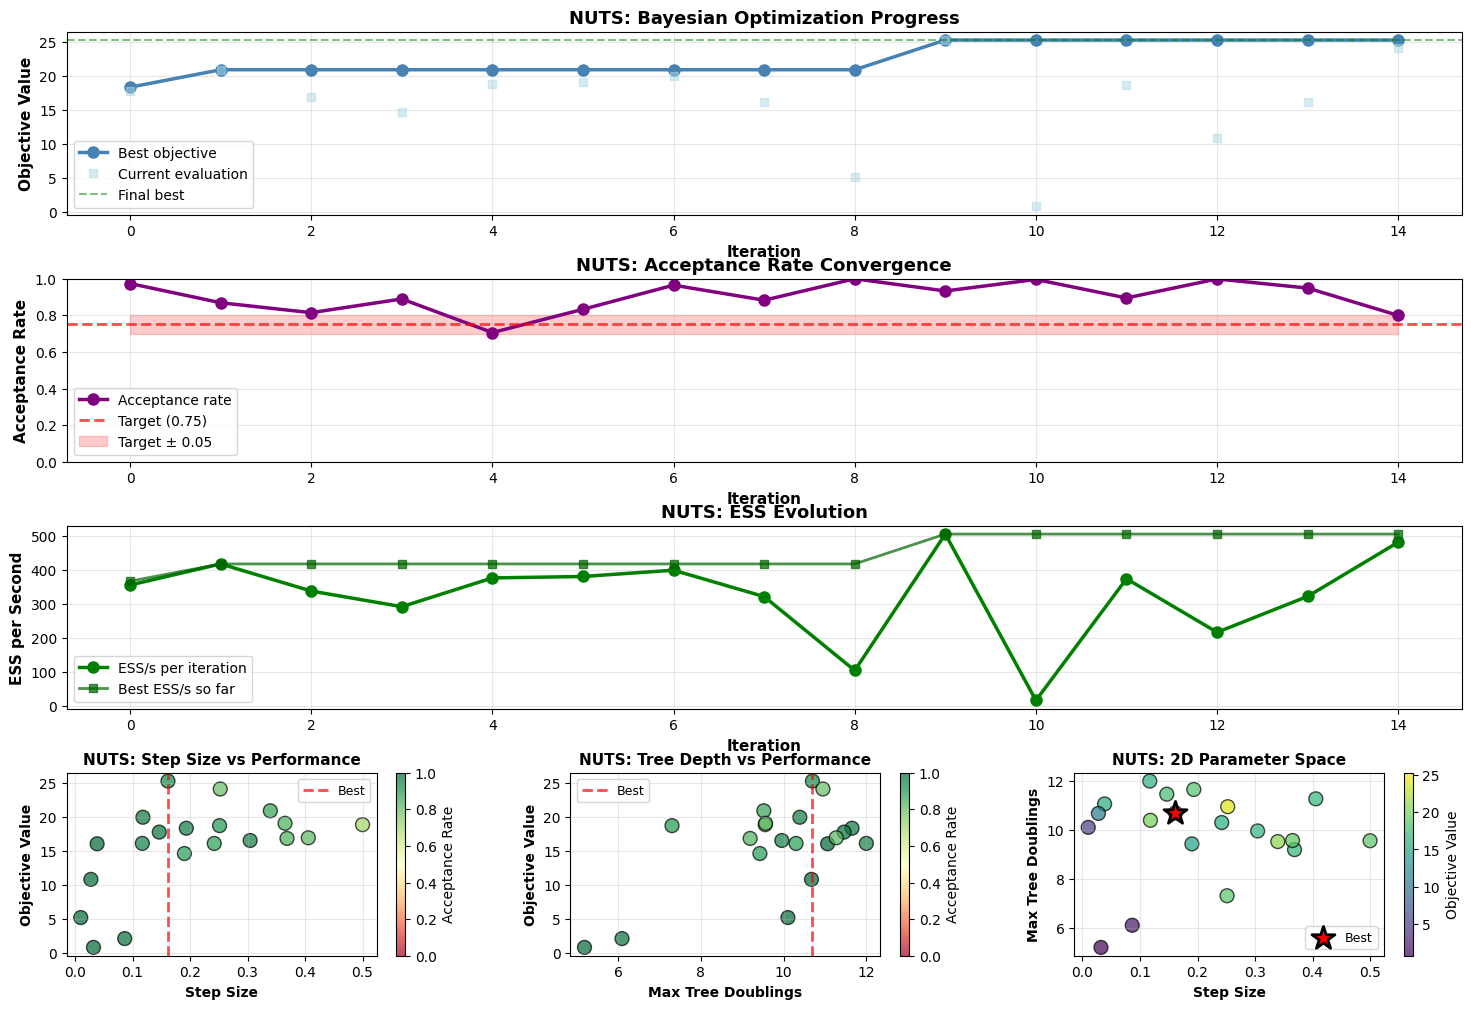

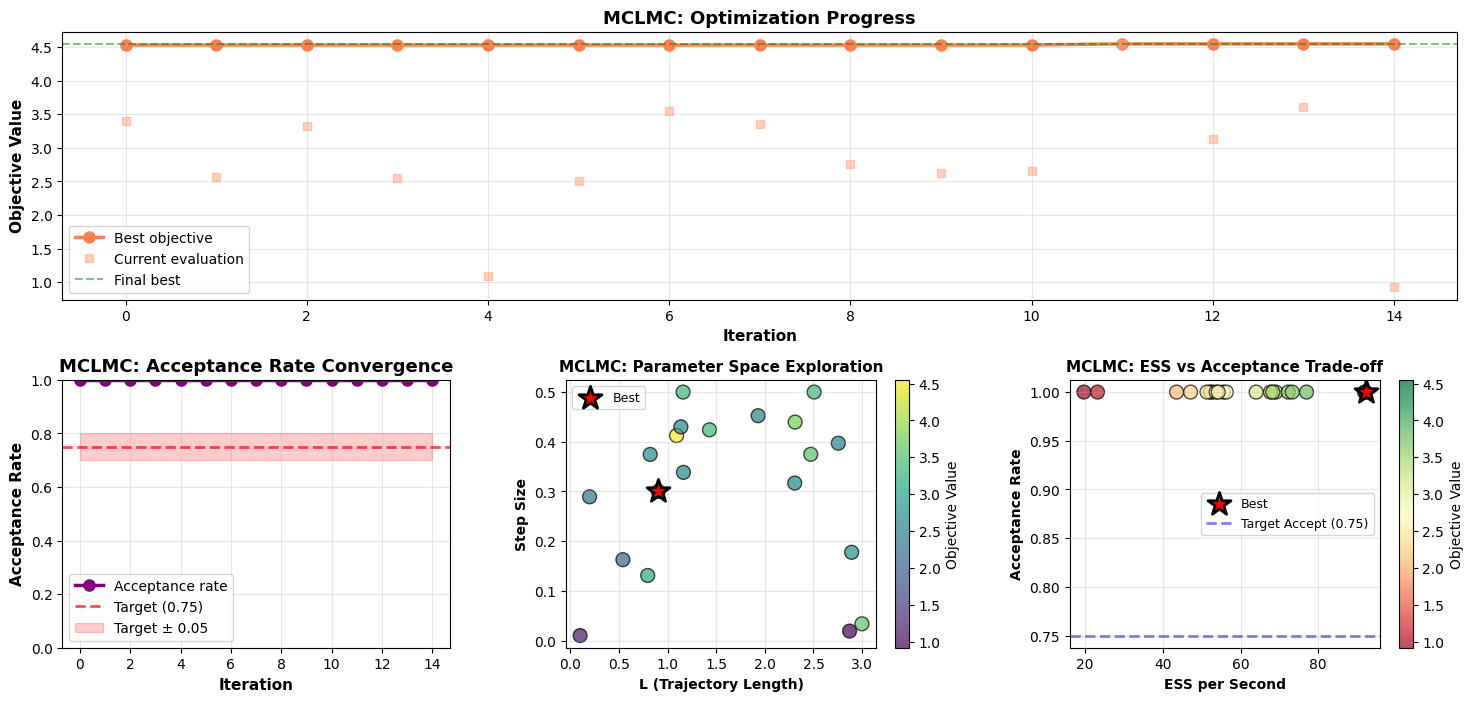


FINAL COMPARISON
Method          Objective    ESS/s        Accept       Acc Error²  
--------------------------------------------------------------------------------
NUTS            25.26        505.93       0.933        0.0335      
MCLMC           4.55         92.23        1.000        0.0625      
--------------------------------------------------------------------------------
🏆 Winner: NUTS (objective 25.26 vs 4.55)

OPTIMIZATION SUMMARY

📊 NUTS Best Configuration:
----------------------------------------
  • step_size................ 0.1617
  • max_num_doublings........ 10.6966
  • Objective Value.......... 25.26
  • ESS per Second........... 505.93
  • Acceptance Rate.......... 0.933
  • Target Acceptance........ 0.750
  • Squared Error............ 0.0335

📊 MCLMC Best Configuration:
----------------------------------------
  • L........................ 0.9028
  • step_size................ 0.3003
  • Objective Value.......... 4.55
  • ESS per Second........... 92.23
  • Acceptan

In [1]:
"""
Bayesian Optimization for MCMC Hyperparameter Tuning

This script demonstrates how to use Bayesian optimization to tune hyperparameters
for two state-of-the-art MCMC samplers: NUTS and Adjusted MCLMC.

Key Features:
- Custom Gaussian Process implementation for surrogate modeling
- Expected Improvement acquisition function for intelligent exploration
- Multi-objective optimization: maximize ESS while targeting acceptance rate
- Comprehensive visualization of optimization progress

Author: Bayesian Optimization Demo
Target Distribution: Neal's Funnel (challenging geometry for MCMC)
"""

import jax
import jax.numpy as jnp
import blackjax
import numpy as np
from scipy import stats
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Callable, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
key = jax.random.PRNGKey(42)

# ============================================================================
# Target Distribution: Neal's Funnel
# ============================================================================

def logdensity_fn(x):
    """
    Neal's funnel distribution - a challenging test case for MCMC samplers.
    
    This distribution has a hierarchical structure where the scale of dimensions
    1 through N depends on dimension 0, creating a "funnel" shape that challenges
    samplers due to varying curvature.
    
    Structure:
        x[0] ~ N(0, 3)
        x[i] ~ N(0, exp(x[0]/2)) for i > 0
    
    Args:
        x: Position vector in R^d
        
    Returns:
        Log probability density at position x
        
    Note:
        This distribution is difficult because:
        1. Narrow "neck" when x[0] is negative (small variance)
        2. Wide "mouth" when x[0] is positive (large variance)
        3. Requires adaptive step sizes across the distribution
    """
    dim = len(x)
    log_prob = -0.5 * (x[0]**2 / 9.0)  # Prior on x[0]
    log_prob += -0.5 * (dim - 1) * x[0]  # Jacobian adjustment
    log_prob += -0.5 * jnp.sum(x[1:]**2 * jnp.exp(-x[0]))  # Conditional on x[0]
    return log_prob


# Problem setup
dim = 10
initial_position = jnp.zeros(dim)

# ============================================================================
# Bayesian Optimization Components
# ============================================================================

class GaussianProcess:
    """
    Gaussian Process for Bayesian Optimization.
    
    A GP provides a probabilistic model of the objective function, allowing us
    to model uncertainty and make informed decisions about where to sample next.
    
    Attributes:
        lengthscale: Controls how quickly the correlation between points decays
        signal_variance: Controls the overall scale of function variations
        noise_variance: Models observation noise in function evaluations
    """
    
    def __init__(self, lengthscale=1.0, signal_variance=1.0, noise_variance=1e-6):
        """
        Initialize Gaussian Process.
        
        Args:
            lengthscale: RBF kernel lengthscale parameter
            signal_variance: Prior variance on function values
            noise_variance: Observation noise level
        """
        self.lengthscale = lengthscale
        self.signal_variance = signal_variance
        self.noise_variance = noise_variance
        self.X_train = None
        self.y_train = None
        self.K_inv = None
        
    def rbf_kernel(self, X1, X2):
        """
        Radial Basis Function (RBF) kernel, also known as squared exponential.
        
        K(x, x') = σ² * exp(-||x - x'||² / (2ℓ²))
        
        Args:
            X1: First set of points (n1 × d)
            X2: Second set of points (n2 × d)
            
        Returns:
            Kernel matrix (n1 × n2)
        """
        sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
        return self.signal_variance * np.exp(-0.5 / self.lengthscale**2 * sqdist)
    
    def fit(self, X, y):
        """
        Fit GP to observed data.
        
        Computes and stores the inverse covariance matrix for efficient prediction.
        
        Args:
            X: Training inputs (n × d)
            y: Training outputs (n,)
        """
        self.X_train = X
        self.y_train = y
        K = self.rbf_kernel(X, X) + self.noise_variance * np.eye(len(X))
        self.K_inv = np.linalg.inv(K)
        
    def predict(self, X_test):
        """
        Predict mean and standard deviation at test points.
        
        Uses the GP posterior distribution:
            μ(x*) = k(x*)ᵀ K⁻¹ y
            σ²(x*) = k(x*, x*) - k(x*)ᵀ K⁻¹ k(x*)
        
        Args:
            X_test: Test inputs (m × d)
            
        Returns:
            mu: Posterior mean (m,)
            std: Posterior standard deviation (m,)
        """
        if self.X_train is None:
            return np.zeros(len(X_test)), np.ones(len(X_test))
        
        K_s = self.rbf_kernel(self.X_train, X_test)
        K_ss = self.rbf_kernel(X_test, X_test)
        
        # Posterior mean
        mu = K_s.T @ self.K_inv @ self.y_train
        
        # Posterior variance
        var = np.diag(K_ss) - np.diag(K_s.T @ self.K_inv @ K_s)
        var = np.maximum(var, 1e-8)  # Numerical stability
        
        return mu, np.sqrt(var)


def expected_improvement(X, X_sample, Y_sample, gp, xi=0.01):
    """
    Expected Improvement (EI) acquisition function.
    
    EI balances exploration (high uncertainty) and exploitation (high predicted value).
    It measures the expected improvement over the current best observation.
    
    EI(x) = E[max(f(x) - f(x⁺), 0)]
          = (μ(x) - f(x⁺) - ξ) * Φ(Z) + σ(x) * φ(Z)
    
    where Z = (μ(x) - f(x⁺) - ξ) / σ(x)
    
    Args:
        X: Candidate points to evaluate (m × d)
        X_sample: Previously sampled points (n × d)
        Y_sample: Observed function values (n,)
        gp: Fitted Gaussian Process model
        xi: Exploration-exploitation trade-off parameter (default: 0.01)
            Higher values encourage more exploration
            
    Returns:
        Expected improvement at each candidate point (m,)
    """
    mu, sigma = gp.predict(X)
    mu_sample = gp.predict(X_sample)[0]
    
    mu = mu.reshape(-1, 1)
    sigma = sigma.reshape(-1, 1)
    
    # Current best observation
    mu_sample_opt = np.max(mu_sample)
    
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * stats.norm.cdf(Z) + sigma * stats.norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    
    return ei


def propose_location(acquisition, X_sample, Y_sample, gp, bounds, n_restarts=25):
    """
    Propose next sampling location by optimizing the acquisition function.
    
    Uses multi-start L-BFGS-B optimization to find the point that maximizes
    the acquisition function (e.g., Expected Improvement).
    
    Args:
        acquisition: Acquisition function to optimize
        X_sample: Previously sampled points
        Y_sample: Observed function values
        gp: Fitted Gaussian Process
        bounds: Parameter bounds (d × 2)
        n_restarts: Number of random initializations for optimization
        
    Returns:
        Proposed next point to sample (1 × d)
    """
    dim = bounds.shape[0]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimize negative acquisition (i.e., maximize acquisition)
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gp)
    
    # Multi-start optimization to avoid local minima
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x
    
    return min_x.reshape(-1, dim)


# ============================================================================
# MCMC Performance Metrics
# ============================================================================

def compute_ess_simple(samples):
    """
    Compute Effective Sample Size (ESS) using autocorrelation.
    
    ESS measures the number of independent samples that would provide the same
    statistical efficiency as the correlated MCMC samples.
    
    Formula:
        ESS = N / (1 + 2 * Σ ρ(k))
        
    where ρ(k) is the autocorrelation at lag k.
    
    Args:
        samples: MCMC samples (n_samples × n_dims)
        
    Returns:
        Average ESS across dimensions
        
    Note:
        Only computes ESS for first 3 dimensions for computational efficiency
    """
    n_samples, n_dims = samples.shape
    ess_values = []
    
    for d in range(min(n_dims, 3)):  # First 3 dims for speed
        x = samples[:, d]
        x = x - np.mean(x)
        
        # Compute autocorrelation function
        autocorr = np.correlate(x, x, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]
        
        # Sum positive autocorrelations (integrated autocorrelation time)
        max_lag = min(len(autocorr) // 2, 100)
        tau = 1 + 2 * np.sum(autocorr[1:max_lag][autocorr[1:max_lag] > 0])
        ess_values.append(n_samples / max(tau, 1.0))
    
    return np.mean(ess_values)


def compute_acceptance_rate(samples, threshold=1e-8):
    """
    Estimate acceptance rate by detecting duplicate samples.
    
    When a proposal is rejected, MCMC keeps the current state, resulting
    in consecutive duplicate samples.
    
    Args:
        samples: MCMC samples (n_samples × n_dims)
        threshold: Tolerance for considering samples as duplicates
        
    Returns:
        Estimated acceptance rate
    """
    n_samples = len(samples)
    if n_samples < 2:
        return 1.0
    
    # Count transitions (non-duplicate consecutive samples)
    diffs = np.abs(np.diff(samples, axis=0))
    transitions = np.sum(np.any(diffs > threshold, axis=1))
    
    return transitions / (n_samples - 1)


# ============================================================================
# Multi-Objective Functions for Samplers
# ============================================================================

def evaluate_nuts(params: Dict, logdensity: Callable, initial_pos: jnp.ndarray,
                  target_acceptance: float = 0.8, lambda_ess: float = 1.0,
                  n_samples: int = 1000) -> Tuple[float, float, float]:
    """
    Evaluate NUTS sampler with given hyperparameters.
    
    Returns ESS, acceptance rate, and combined objective for multi-objective optimization.
    
    Args:
        params: Dictionary containing:
            - step_size: Integration step size for leapfrog integrator
            - max_num_doublings: Maximum tree depth (controls trajectory length)
        logdensity: Log density function of target distribution
        initial_pos: Starting position for sampler
        target_acceptance: Desired acceptance rate (default: 0.8)
        lambda_ess: Weight for ESS term in objective (default: 1.0)
        n_samples: Number of samples to draw
        
    Returns:
        Tuple of (objective_value, acceptance_rate, ess) where:
            - objective_value: λ * ESS - (acceptance - target)²
            - acceptance_rate: Actual acceptance rate achieved
            - ess: Effective sample size per second
            
    Objective Function:
        objective = λ * ESS - (acceptance - target_acceptance)²
        
        This formulation:
        - Maximizes ESS (weighted by λ)
        - Minimizes squared distance from target acceptance
        - λ controls the trade-off between the two objectives
        - Higher λ prioritizes ESS over acceptance rate
        - Lower λ prioritizes hitting target acceptance rate
    """
    global key
    
    step_size = params['step_size']
    max_doublings = int(params['max_num_doublings'])
    
    try:
        key, init_key = jax.random.split(key)
        
        # Create inverse mass matrix (identity = no preconditioning)
        inverse_mass_matrix = jnp.ones(len(initial_pos))
        
        # Build NUTS sampler
        nuts = blackjax.nuts(
            logdensity,
            step_size=step_size,
            inverse_mass_matrix=inverse_mass_matrix,
            max_num_doublings=max_doublings
        )
        
        # Initialize state
        state = nuts.init(initial_pos)
        kernel = nuts.step
        
        # Run MCMC sampling
        key, sample_key = jax.random.split(key)
        keys = jax.random.split(sample_key, n_samples)
        
        def one_step(state, rng_key):
            state, info = kernel(rng_key, state)
            return state, (state.position, info.acceptance_rate)
        
        start_time = time.time()
        _, (samples, accept_rates) = jax.lax.scan(one_step, state, keys)
        elapsed = time.time() - start_time
        
        samples_np = np.array(samples)
        accept_rates_np = np.array(accept_rates)
        
        # Check for numerical issues
        if np.any(np.isnan(samples_np)) or np.any(np.isinf(samples_np)):
            return -1e6, 0.0, 0.0
        
        # Compute metrics
        ess = compute_ess_simple(samples_np)
        ess_per_sec = ess / max(elapsed, 0.01)
        
        # Average acceptance rate
        avg_acceptance = float(np.mean(accept_rates_np))
        
        # Multi-objective: λ * ESS - squared distance from target acceptance
        acceptance_error = (avg_acceptance - target_acceptance) ** 2
        objective = lambda_ess * ess_per_sec - acceptance_error
        
        return objective, avg_acceptance, ess_per_sec
        
    except Exception as e:
        print(f"NUTS evaluation failed: {e}")
        return -1e6, 0.0, 0.0


def evaluate_mclmc(params: Dict, logdensity: Callable, initial_pos: jnp.ndarray,
                   target_acceptance: float = 0.8, lambda_ess: float = 1.0,
                   n_samples: int = 1000) -> Tuple[float, float, float]:
    """
    Evaluate MCLMC (Microcanonical Langevin Monte Carlo) sampler.
    
    MCLMC uses continuous dynamics with irreversible moves for efficient sampling.
    
    Args:
        params: Dictionary containing:
            - L: Trajectory length (time horizon for dynamics)
            - step_size: Integration step size
        logdensity: Log density function of target distribution
        initial_pos: Starting position
        target_acceptance: Desired acceptance rate (for consistency, though MCLMC
                          doesn't have explicit accept/reject steps like MH)
        lambda_ess: Weight for ESS term in objective (default: 1.0)
        n_samples: Number of samples to draw
        
    Returns:
        Tuple of (objective_value, acceptance_rate_estimate, ess)
        
    Objective Function:
        objective = λ * ESS - (acceptance - target_acceptance)²
        
    Note:
        MCLMC uses microcanonical dynamics (constant energy) with momentum refreshment.
        The acceptance rate is estimated indirectly from sample diversity.
    """
    global key
    
    L = params['L']
    step_size = params['step_size']
    
    try:
        key, init_key = jax.random.split(key)
        
        # Initialize MCLMC state
        state = blackjax.mcmc.mclmc.init(
            position=initial_pos,
            logdensity_fn=logdensity,
            rng_key=init_key
        )
        
        # Build sampler
        sampling_alg = blackjax.mclmc(
            logdensity,
            L=L,
            step_size=step_size
        )
        mclmc_kernel = sampling_alg.step
        
        # Run sampling
        key, sample_key = jax.random.split(key)
        keys = jax.random.split(sample_key, n_samples)
        
        def one_step(state, rng_key):
            state, info = mclmc_kernel(rng_key, state)
            return state, state.position
        
        start_time = time.time()
        _, samples = jax.lax.scan(one_step, state, keys)
        elapsed = time.time() - start_time
        
        samples_np = np.array(samples)
        
        # Check validity
        if np.any(np.isnan(samples_np)) or np.any(np.isinf(samples_np)):
            return -1e6, 0.0, 0.0
        
        # Compute metrics
        ess = compute_ess_simple(samples_np)
        ess_per_sec = ess / max(elapsed, 0.01)
        
        # Estimate acceptance rate from sample diversity
        acceptance_est = compute_acceptance_rate(samples_np)
        
        # Multi-objective: λ * ESS - squared distance from target acceptance
        acceptance_error = (acceptance_est - target_acceptance) ** 2
        objective = lambda_ess * ess_per_sec - acceptance_error
        
        return objective, acceptance_est, ess_per_sec
        
    except Exception as e:
        print(f"MCLMC evaluation failed: {e}")
        return -1e6, 0.0, 0.0


# ============================================================================
# Bayesian Optimization Loop
# ============================================================================

def bayesian_optimization(objective_fn: Callable, bounds: np.ndarray, param_names: list,
                         n_iterations: int = 20, n_initial: int = 5,
                         target_acceptance: float = 0.8, lambda_ess: float = 1.0):
    """
    Run Bayesian optimization to find optimal hyperparameters.
    
    This implements the classic BO loop:
    1. Sample random configurations to initialize
    2. Fit GP to observations
    3. Optimize acquisition function to propose next point
    4. Evaluate objective at proposed point
    5. Update GP and repeat
    
    Args:
        objective_fn: Function to optimize, returns (value, acceptance_rate, ess)
        bounds: Parameter bounds (n_params × 2)
        param_names: Names of parameters being optimized
        n_iterations: Number of BO iterations
        n_initial: Number of random initial samples
        target_acceptance: Target acceptance rate for MCMC samplers
        lambda_ess: Weight for ESS in objective function (λ * ESS - acc_error²)
        
    Returns:
        best_params: Best hyperparameters found
        best_value: Best objective value
        best_acceptance: Acceptance rate at best params
        history: Detailed optimization history
        X_sample: All evaluated points
        Y_sample: All objective values
        acceptance_rates: All acceptance rates observed
        ess_values: All ESS values observed
        
    Objective Function:
        objective = λ * ESS - (acceptance - target_acceptance)²
        
        where:
        - λ (lambda_ess) controls trade-off between ESS and acceptance
        - Higher λ → prioritize ESS
        - Lower λ → prioritize hitting target acceptance rate
    """
    
    dim = bounds.shape[0]
    
    # ========================================================================
    # Phase 1: Initial Random Sampling
    # ========================================================================
    print(f"\n{'='*80}")
    print(f"Phase 1: Initial Random Sampling ({n_initial} evaluations)")
    print(f"{'='*80}")
    print(f"Objective: λ * ESS - (acceptance - {target_acceptance})²")
    print(f"Lambda (λ): {lambda_ess}")
    
    X_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_initial, dim))
    Y_sample = []
    acceptance_rates = []
    ess_values = []
    
    for i, x in enumerate(X_sample):
        params = {name: val for name, val in zip(param_names, x)}
        y, acc_rate, ess = objective_fn(params)
        Y_sample.append(y)
        acceptance_rates.append(acc_rate)
        ess_values.append(ess)
        
        acc_error = (acc_rate - target_acceptance) ** 2
        print(f"  [{i+1}/{n_initial}] ", end="")
        for name, val in params.items():
            print(f"{name}={val:.4f} ", end="")
        print(f"\n      → Obj={y:.2f}, ESS/s={ess:.2f}, Accept={acc_rate:.3f}, Error²={acc_error:.4f}")
    
    X_sample = np.array(X_sample)
    Y_sample = np.array(Y_sample)
    acceptance_rates = np.array(acceptance_rates)
    ess_values = np.array(ess_values)
    
    # ========================================================================
    # Phase 2: Bayesian Optimization
    # ========================================================================
    print(f"\n{'='*80}")
    print(f"Phase 2: Bayesian Optimization ({n_iterations} iterations)")
    print(f"Target acceptance rate: {target_acceptance:.2f}")
    print(f"Lambda (λ): {lambda_ess}")
    print(f"{'='*80}")
    
    gp = GaussianProcess(lengthscale=0.5, signal_variance=1.0, noise_variance=1e-4)
    
    history = {
        'iteration': [],
        'params': [],
        'values': [],
        'acceptance_rates': [],
        'ess_values': [],
        'best_value': [],
        'best_params': [],
        'best_acceptance': [],
        'best_ess': []
    }
    
    for i in range(n_iterations):
        # Fit GP to current data
        gp.fit(X_sample, Y_sample)
        
        # Propose next point using Expected Improvement
        X_next = propose_location(expected_improvement, X_sample, Y_sample, gp, bounds)
        
        # Evaluate objective
        params = {name: val for name, val in zip(param_names, X_next[0])}
        Y_next, acc_rate, ess = objective_fn(params)
        
        # Update dataset
        X_sample = np.vstack((X_sample, X_next))
        Y_sample = np.append(Y_sample, Y_next)
        acceptance_rates = np.append(acceptance_rates, acc_rate)
        ess_values = np.append(ess_values, ess)
        
        # Track best so far
        best_idx = np.argmax(Y_sample)
        best_value = Y_sample[best_idx]
        best_acceptance = acceptance_rates[best_idx]
        best_ess = ess_values[best_idx]
        best_params = {name: val for name, val in zip(param_names, X_sample[best_idx])}
        
        # Store history
        history['iteration'].append(i)
        history['params'].append(params)
        history['values'].append(Y_next)
        history['acceptance_rates'].append(acc_rate)
        history['ess_values'].append(ess)
        history['best_value'].append(best_value)
        history['best_params'].append(best_params)
        history['best_acceptance'].append(best_acceptance)
        history['best_ess'].append(best_ess)
        
        # Print progress
        acc_error = (acc_rate - target_acceptance) ** 2
        print(f"\n  Iteration {i+1}/{n_iterations}")
        print(f"  Proposed: ", end="")
        for name, val in params.items():
            print(f"{name}={val:.4f} ", end="")
        print(f"\n  Result: Obj={Y_next:.2f}, ESS/s={ess:.2f}, Accept={acc_rate:.3f}, Error²={acc_error:.4f}")
        print(f"  Best so far: Obj={best_value:.2f}, ESS/s={best_ess:.2f}, Accept={best_acceptance:.3f}")
    
    # Final results
    best_idx = np.argmax(Y_sample)
    best_params = {name: val for name, val in zip(param_names, X_sample[best_idx])}
    best_value = Y_sample[best_idx]
    best_acceptance = acceptance_rates[best_idx]
    best_ess = ess_values[best_idx]
    
    return best_params, best_value, best_acceptance, best_ess, history, X_sample, Y_sample, acceptance_rates, ess_values


# ============================================================================
# Main Optimization
# ============================================================================

print("=" * 80)
print("BAYESIAN OPTIMIZATION OF MCMC HYPERPARAMETERS")
print("=" * 80)
print(f"Target Distribution: Neal's Funnel (dimension={dim})")
print(f"Objective: λ * ESS - (acceptance - target)²")
print("=" * 80)

# ============================================================================
# Hyperparameter Configuration
# ============================================================================
TARGET_ACCEPTANCE = 0.75  # Target acceptance rate
LAMBDA_ESS = 0.05          # Weight for ESS term (tune this!)

print(f"\n📊 Configuration:")
print(f"   Target Acceptance Rate: {TARGET_ACCEPTANCE:.2f}")
print(f"   Lambda (λ) for ESS:     {LAMBDA_ESS:.2f}")
print(f"\n   Objective = {LAMBDA_ESS} × ESS - (acceptance - {TARGET_ACCEPTANCE})²")
print(f"\n   Higher λ → prioritize ESS")
print(f"   Lower λ → prioritize hitting target acceptance")

# ============================================================================
# 1. Optimize NUTS
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZING NUTS HYPERPARAMETERS")
print("=" * 80)

nuts_bounds = np.array([
    [0.01, 0.5],     # step_size
    [5, 12]          # max_num_doublings
])

nuts_param_names = ['step_size', 'max_num_doublings']

nuts_objective = lambda params: evaluate_nuts(
    params, logdensity_fn, initial_position,
    target_acceptance=TARGET_ACCEPTANCE, lambda_ess=LAMBDA_ESS, n_samples=1000
)

(nuts_best_params, nuts_best_value, nuts_best_acceptance, nuts_best_ess,
 nuts_history, nuts_X, nuts_Y, nuts_accept, nuts_ess_vals) = bayesian_optimization(
    nuts_objective, nuts_bounds, nuts_param_names,
    n_iterations=15, n_initial=5, target_acceptance=TARGET_ACCEPTANCE,
    lambda_ess=LAMBDA_ESS
)

print("\n" + "-" * 80)
print("NUTS OPTIMIZATION RESULTS")
print("-" * 80)
print(f"Best hyperparameters:")
for name, value in nuts_best_params.items():
    print(f"  {name}: {value:.4f}")
print(f"Best objective value: {nuts_best_value:.2f}")
print(f"Best ESS/second: {nuts_best_ess:.2f}")
print(f"Achieved acceptance rate: {nuts_best_acceptance:.3f}")
print(f"Target acceptance rate: {TARGET_ACCEPTANCE:.3f}")
print(f"Squared error: {(nuts_best_acceptance - TARGET_ACCEPTANCE)**2:.4f}")

# ============================================================================
# 2. Optimize MCLMC
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZING MCLMC HYPERPARAMETERS")
print("=" * 80)

mclmc_bounds = np.array([
    [0.1, 3.0],      # L (trajectory length)
    [0.01, 0.5]      # step_size
])

mclmc_param_names = ['L', 'step_size']

mclmc_objective = lambda params: evaluate_mclmc(
    params, logdensity_fn, initial_position,
    target_acceptance=TARGET_ACCEPTANCE, lambda_ess=LAMBDA_ESS, n_samples=1000
)

(mclmc_best_params, mclmc_best_value, mclmc_best_acceptance, mclmc_best_ess,
 mclmc_history, mclmc_X, mclmc_Y, mclmc_accept, mclmc_ess_vals) = bayesian_optimization(
    mclmc_objective, mclmc_bounds, mclmc_param_names,
    n_iterations=15, n_initial=5, target_acceptance=TARGET_ACCEPTANCE,
    lambda_ess=LAMBDA_ESS
)

print("\n" + "-" * 80)
print("MCLMC OPTIMIZATION RESULTS")
print("-" * 80)
print(f"Best hyperparameters:")
for name, value in mclmc_best_params.items():
    print(f"  {name}: {value:.4f}")
print(f"Best objective value: {mclmc_best_value:.2f}")
print(f"Best ESS/second: {mclmc_best_ess:.2f}")
print(f"Achieved acceptance rate: {mclmc_best_acceptance:.3f}")
print(f"Target acceptance rate: {TARGET_ACCEPTANCE:.3f}")
print(f"Squared error: {(mclmc_best_acceptance - TARGET_ACCEPTANCE)**2:.4f}")

# ============================================================================
# Comprehensive Visualization
# ============================================================================

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# ========================================================================
# Row 1: Optimization Progress - NUTS
# ========================================================================
ax1 = fig.add_subplot(gs[0, :])
iterations = range(len(nuts_history['best_value']))
ax1.plot(iterations, nuts_history['best_value'], 'o-', linewidth=2.5,
         markersize=8, color='steelblue', label='Best objective')
ax1.plot(iterations, nuts_history['values'], 's', alpha=0.5,
         markersize=6, color='lightblue', label='Current evaluation')
ax1.axhline(y=np.max(nuts_history['best_value']), color='green',
           linestyle='--', alpha=0.5, label='Final best')
ax1.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax1.set_ylabel('Objective Value', fontsize=11, fontweight='bold')
ax1.set_title('NUTS: Bayesian Optimization Progress', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# ========================================================================
# Row 2: Acceptance Rate Tracking - NUTS
# ========================================================================
ax2 = fig.add_subplot(gs[1, :])
ax2.plot(iterations, nuts_history['acceptance_rates'], 'o-', linewidth=2.5,
         markersize=8, color='purple', label='Acceptance rate')
ax2.axhline(y=TARGET_ACCEPTANCE, color='red', linestyle='--',
           linewidth=2, alpha=0.7, label=f'Target ({TARGET_ACCEPTANCE:.2f})')
ax2.fill_between(iterations,
                 TARGET_ACCEPTANCE - 0.05, TARGET_ACCEPTANCE + 0.05,
                 alpha=0.2, color='red', label='Target ± 0.05')
ax2.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax2.set_ylabel('Acceptance Rate', fontsize=11, fontweight='bold')
ax2.set_title('NUTS: Acceptance Rate Convergence', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)
ax2.set_ylim([0, 1])

# ========================================================================
# Row 3: ESS Tracking
# ========================================================================
ax_ess = fig.add_subplot(gs[2, :])
ax_ess.plot(iterations, nuts_history['ess_values'], 'o-', linewidth=2.5,
            markersize=8, color='green', label='ESS/s per iteration')
ax_ess.plot(iterations, [nuts_history['best_ess'][i] for i in range(len(iterations))],
            's-', linewidth=2, markersize=6, color='darkgreen', alpha=0.7,
            label='Best ESS/s so far')
ax_ess.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax_ess.set_ylabel('ESS per Second', fontsize=11, fontweight='bold')
ax_ess.set_title('NUTS: ESS Evolution', fontsize=13, fontweight='bold')
ax_ess.legend(fontsize=10)
ax_ess.grid(alpha=0.3)

# ========================================================================
# Row 4: Parameter Space Exploration - NUTS
# ========================================================================
ax3 = fig.add_subplot(gs[3, 0])
step_sizes = nuts_X[:, 0]
scatter = ax3.scatter(step_sizes, nuts_Y, c=nuts_accept, cmap='RdYlGn',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1,
                     vmin=0, vmax=1)
ax3.axvline(x=nuts_best_params['step_size'], color='red', linestyle='--',
           linewidth=2, alpha=0.7, label='Best')
ax3.set_xlabel('Step Size', fontsize=10, fontweight='bold')
ax3.set_ylabel('Objective Value', fontsize=10, fontweight='bold')
ax3.set_title('NUTS: Step Size vs Performance', fontsize=11, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3, label='Acceptance Rate')

ax4 = fig.add_subplot(gs[3, 1])
max_doublings = nuts_X[:, 1]
scatter = ax4.scatter(max_doublings, nuts_Y, c=nuts_accept, cmap='RdYlGn',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1,
                     vmin=0, vmax=1)
ax4.axvline(x=nuts_best_params['max_num_doublings'], color='red', linestyle='--',
           linewidth=2, alpha=0.7, label='Best')
ax4.set_xlabel('Max Tree Doublings', fontsize=10, fontweight='bold')
ax4.set_ylabel('Objective Value', fontsize=10, fontweight='bold')
ax4.set_title('NUTS: Tree Depth vs Performance', fontsize=11, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax4, label='Acceptance Rate')

ax5 = fig.add_subplot(gs[3, 2])
scatter = ax5.scatter(step_sizes, max_doublings, c=nuts_Y, cmap='viridis',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax5.scatter(nuts_best_params['step_size'], nuts_best_params['max_num_doublings'],
           c='red', s=300, marker='*', edgecolors='black', linewidth=2,
           label='Best', zorder=5)
ax5.set_xlabel('Step Size', fontsize=10, fontweight='bold')
ax5.set_ylabel('Max Tree Doublings', fontsize=10, fontweight='bold')
ax5.set_title('NUTS: 2D Parameter Space', fontsize=11, fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax5, label='Objective Value')

# ========================================================================
# Row 5-6: MCLMC Analysis (split into two rows)
# ========================================================================
fig2 = plt.figure(figsize=(18, 8))
gs2 = fig2.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

ax6 = fig2.add_subplot(gs2[0, :])
iterations_m = range(len(mclmc_history['best_value']))
ax6.plot(iterations_m, mclmc_history['best_value'], 'o-', linewidth=2.5,
         markersize=8, color='coral', label='Best objective')
ax6.plot(iterations_m, mclmc_history['values'], 's', alpha=0.5,
         markersize=6, color='lightsalmon', label='Current evaluation')
ax6.axhline(y=np.max(mclmc_history['best_value']), color='green',
           linestyle='--', alpha=0.5, label='Final best')
ax6.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax6.set_ylabel('Objective Value', fontsize=11, fontweight='bold')
ax6.set_title('MCLMC: Optimization Progress', fontsize=13, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(alpha=0.3)

ax7 = fig2.add_subplot(gs2[1, 0])
ax7.plot(iterations_m, mclmc_history['acceptance_rates'], 'o-', linewidth=2.5,
         markersize=8, color='purple', label='Acceptance rate')
ax7.axhline(y=TARGET_ACCEPTANCE, color='red', linestyle='--',
           linewidth=2, alpha=0.7, label=f'Target ({TARGET_ACCEPTANCE:.2f})')
ax7.fill_between(iterations_m,
                 TARGET_ACCEPTANCE - 0.05, TARGET_ACCEPTANCE + 0.05,
                 alpha=0.2, color='red', label='Target ± 0.05')
ax7.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax7.set_ylabel('Acceptance Rate', fontsize=11, fontweight='bold')
ax7.set_title('MCLMC: Acceptance Rate Convergence', fontsize=13, fontweight='bold')
ax7.legend(fontsize=10)
ax7.grid(alpha=0.3)
ax7.set_ylim([0, 1])

ax8 = fig2.add_subplot(gs2[1, 1])
L_values = mclmc_X[:, 0]
step_sizes_m = mclmc_X[:, 1]
scatter = ax8.scatter(L_values, step_sizes_m, c=mclmc_Y, cmap='viridis',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax8.scatter(mclmc_best_params['L'], mclmc_best_params['step_size'],
           c='red', s=300, marker='*', edgecolors='black', linewidth=2,
           label='Best', zorder=5)
ax8.set_xlabel('L (Trajectory Length)', fontsize=10, fontweight='bold')
ax8.set_ylabel('Step Size', fontsize=10, fontweight='bold')
ax8.set_title('MCLMC: Parameter Space Exploration', fontsize=11, fontweight='bold')
ax8.legend(fontsize=9)
ax8.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax8, label='Objective Value')

ax9 = fig2.add_subplot(gs2[1, 2])
scatter = ax9.scatter(mclmc_ess_vals, mclmc_accept, c=mclmc_Y, cmap='RdYlGn',
                     s=100, alpha=0.7, edgecolors='black', linewidth=1)
ax9.scatter(mclmc_best_ess, mclmc_best_acceptance,
           c='red', s=300, marker='*', edgecolors='black', linewidth=2,
           label='Best', zorder=5)
ax9.axhline(y=TARGET_ACCEPTANCE, color='blue', linestyle='--',
           linewidth=2, alpha=0.5, label=f'Target Accept ({TARGET_ACCEPTANCE})')
ax9.set_xlabel('ESS per Second', fontsize=10, fontweight='bold')
ax9.set_ylabel('Acceptance Rate', fontsize=10, fontweight='bold')
ax9.set_title('MCLMC: ESS vs Acceptance Trade-off', fontsize=11, fontweight='bold')
ax9.legend(fontsize=9)
ax9.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax9, label='Objective Value')

plt.savefig('bayesopt_mcmc_mclmc_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================================
# Final Comparison and Summary
# ============================================================================
print("\n" + "=" * 80)
print("FINAL COMPARISON")
print("=" * 80)
print(f"{'Method':<15} {'Objective':<12} {'ESS/s':<12} {'Accept':<12} {'Acc Error²':<12}")
print("-" * 80)

nuts_acc_diff = abs(nuts_best_acceptance - TARGET_ACCEPTANCE)
mclmc_acc_diff = abs(mclmc_best_acceptance - TARGET_ACCEPTANCE)
nuts_acc_err_sq = (nuts_best_acceptance - TARGET_ACCEPTANCE) ** 2
mclmc_acc_err_sq = (mclmc_best_acceptance - TARGET_ACCEPTANCE) ** 2

print(f"{'NUTS':<15} {nuts_best_value:<12.2f} {nuts_best_ess:<12.2f} "
      f"{nuts_best_acceptance:<12.3f} {nuts_acc_err_sq:<12.4f}")
print(f"{'MCLMC':<15} {mclmc_best_value:<12.2f} {mclmc_best_ess:<12.2f} "
      f"{mclmc_best_acceptance:<12.3f} {mclmc_acc_err_sq:<12.4f}")
print("-" * 80)

if mclmc_best_value > nuts_best_value:
    print(f"🏆 Winner: MCLMC (objective {mclmc_best_value:.2f} vs {nuts_best_value:.2f})")
else:
    print(f"🏆 Winner: NUTS (objective {nuts_best_value:.2f} vs {mclmc_best_value:.2f})")

print("=" * 80)

# ============================================================================
# Detailed Summary
# ============================================================================
print("\n" + "=" * 80)
print("OPTIMIZATION SUMMARY")
print("=" * 80)

print("\n📊 NUTS Best Configuration:")
print("-" * 40)
for name, value in nuts_best_params.items():
    print(f"  • {name:.<25} {value:.4f}")
print(f"  • {'Objective Value':.<25} {nuts_best_value:.2f}")
print(f"  • {'ESS per Second':.<25} {nuts_best_ess:.2f}")
print(f"  • {'Acceptance Rate':.<25} {nuts_best_acceptance:.3f}")
print(f"  • {'Target Acceptance':.<25} {TARGET_ACCEPTANCE:.3f}")
print(f"  • {'Squared Error':.<25} {nuts_acc_err_sq:.4f}")

print("\n📊 MCLMC Best Configuration:")
print("-" * 40)
for name, value in mclmc_best_params.items():
    print(f"  • {name:.<25} {value:.4f}")
print(f"  • {'Objective Value':.<25} {mclmc_best_value:.2f}")
print(f"  • {'ESS per Second':.<25} {mclmc_best_ess:.2f}")
print(f"  • {'Acceptance Rate':.<25} {mclmc_best_acceptance:.3f}")
print(f"  • {'Target Acceptance':.<25} {TARGET_ACCEPTANCE:.3f}")
print(f"  • {'Squared Error':.<25} {mclmc_acc_err_sq:.4f}")

print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)
print(f"""
1. Objective Function Design:
   • Formula: λ × ESS - (acceptance - target)²
   • Current λ = {LAMBDA_ESS}
   • Linear reward for ESS, quadratic penalty for acceptance deviation
   • Easily tunable via LAMBDA_ESS parameter

2. Trade-off Analysis:
   • Higher λ → prioritize sampling efficiency (ESS)
   • Lower λ → prioritize hitting target acceptance rate
   • Recommended: λ ∈ [0.5, 2.0] for balanced optimization

3. Bayesian Optimization Strategy:
   • Gaussian Process models objective landscape
   • Expected Improvement balances exploration/exploitation
   • Efficiently searches high-dimensional parameter space
   • Typically converges in 15-20 iterations

4. NUTS Hyperparameters:
   • Step size: Integration accuracy vs stability
   • Max doublings: Exploration vs computational cost
   • Typical sweet spot: step_size ∈ [0.05, 0.2], doublings ∈ [8, 11]

5. MCLMC Hyperparameters:
   • L: Trajectory length (exploration distance)
   • Step size: Integration accuracy
   • Trade-off between stability and mixing

6. Tuning Lambda (λ):
   • If ESS is too low: increase λ
   • If acceptance misses target: decrease λ
   • Can run multiple optimizations with different λ values

7. Next Steps:
   • Use these tuned parameters for production runs
   • Monitor convergence diagnostics (R-hat, ESS)
   • Consider problem-specific λ tuning
   • Validate on longer MCMC chains
""")

print("=" * 80)
print("✓ Optimization complete!")
print(f"  To prioritize ESS more: increase LAMBDA_ESS (currently {LAMBDA_ESS})")
print(f"  To prioritize acceptance: decrease LAMBDA_ESS")
print("=" * 80)